# Individual Analysis for the M&ouml;ssbauer experiment

## Full analysis template

**This template walks through the analysis starting from the raw MCA spectrum files and associated velocity transducer measurements for each sample.  If you opt to use the LabVIEW data analysis window to obtain the spectrum peak positions and widths, you should use the *Mossbauer Results-Only Analysis* template.**

Use this template to carry out the analysis tasks for the experiment.  For reference, here are links to recommended Python resources: the [Whirlwind Tour of Python](https://jakevdp.github.io/WhirlwindTourOfPython/) and the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) both by Jake VanderPlas.

We will be making use of both the [Uncertainties](https://pythonhosted.org/uncertainties/) and [LMFit](https://lmfit.github.io/lmfit-py/) packages in this notebook.

In [167]:
from os import read
from statistics import mean

import numpy as np  # import the numpy library functions.
import matplotlib.pyplot as plt # plotting functions
import uncertainties as unc
from numpy.ma.extras import average
from sympy.physics.units import quart
from sympy.printing.codeprinter import print_rust_code
from uncertainties import unumpy, ufloat, umath # Uncertainties package.  Good for simple error propagation
import pandas as pd
import scipy as sp
from lmfit.models import QuadraticModel, LorentzianModel
%matplotlib inline

### Tasks for this analysis

For each spectrum:

1. Use the peak-to-peak amplitude from the velocity transducer and to create a calibration function (a line).  You will need the function generator period and MCS dwell time.  The function should return a velocity in mm/s given a channel number.  Negative velocities should indicate negative energy shifts, and positive velocities should indicate positive energy shifts.

2. Apply your calibration function to the spectrum data sets for all spectra and plot them.

3. Use LMFit and follow the tutorial on fitting a complicated multi-peak function to a data set to fit the absorption peaks to Lorentzians plus a parabolic (2nd order polynomial) background. (Note: you may, if you wish, fit each peak at a time rather than fit the entire spectrum with one complicated curve.)

4. From the fits, obtain the peak center (with uncertainty) and peak width for each peak in each spectrum.  Record these results in tables, one table for each sample.  

You will use the peak positions in mm/s to complete the data analysis.


### Create the calibration function(s)

Think carefully about the motion of the source: where is it at the begining of the scan?  which direction is it moving? 

Think carefully about the dwell time and how long an MCS cycle takes.  (One cycle is a run through all channels.)  At which channel is the velocity zero?  Which channel would have the highest velocity forward and which would have the highest velocity in reverse.  Once you know this, you create a line that interpolates between these points. 

In [168]:
# Python "dictionary" to hold the peak-to-peak velocity transducer readings, in mV
# You supply values and write the function.

Vpp = {'Fe':50.2, 'Nitroprusside':30.8, 'Fe2O3':75.2}
Vpp['Fe2O3']  # Should print the value for the labeled sample


75.2

#### Write the calibration function

Fill in the details below.


In [169]:

Conversion_const = .295# Enter the conversion constant for the transducer in mm/s/(mV)

# Converts a single channel into the velocity
# Parameters:
# - Chan: What channel is wanted
# Returns:
# - Velocity at that channel
def velocity_cal(chan, Vpp=50.0, conv=Conversion_const, dwell=5.0e-4, period=1.00):
    # '''
    # Velocity calibration function.  Converts channel number 'chan' to velocity with sign
    # based on the measured peak-to-peak voltage from the velocity transducer 'Vpp' (in mV),
    # the transducer conversion constant 'conv' (in (mm/s)/mV), the channel dwell time 
    # 'dwell' (in s), and the drive period 'period' (in s).  
    # '''
     # converts to time
    run = .5 * period
    slope = (Vpp * conv) * dwell / run
    intercept = (- Vpp * conv) / 2 
    # voltage = slope * time + init

    # You fill in the details so that the return value below is correct
    return(intercept + slope*(chan+0.5)) # slight correction to place velocity at middle of dwell time (1/2 channel)

a_channel = 250
print("Velocity at channel {} = {:4g} mm/s".format(a_channel, velocity_cal(a_channel,Vpp=Vpp['Fe'])))


Velocity at channel 250 = -3.69485 mm/s


### Work on the first datafile

Read in the first data file and then apply the calibration to convert channel numbers to velocity.  Plot the result.

**Note:**

The calibration, if done correctly, will flip the x-axis of the data set.  Assuming you are doing this on a column in a Pandas dataframe (the default when you read a csv file with `pd.read_csv()`) then the following will reorder the channel array so that the low index is on the left of the plot and the high index is on the right:

`Fe_velocity = velocity_cal(Fe['Chan'],Vpp['Fe']).sort_values()`

where `velocity_cal()` is the calibration function, `Fe['Chan']` is the data from the **Channel** column and `Vpp['Fe']` is the peak-to-peak voltage from the velocity transducer measurement.  The method attached to the end reorders the array from lowest to highest.

***However I recommend the following.***  Just add another column to the dataframe which holds the converted channels-to-velocity.  This makes it easier to deal with slices of the array.  In other words do this:

`Fe['velocity'] = velocity_cal(Fe['Chan'],Vpp['Fe'])`

Then you can reference the original channels when you need to, but pass the velocity to the fitting routines when you need to get results in mm/s.


#### Read in the data file

The raw data files are tab separated two-column files with a one-line header that does not matter for multichannel scaling files.  You need to skip the header and name the columns to create a dataframe.

Use the **Pandas** `read_csv()` function to read the raw data file from the Norland MCA as follows:

    Fe = pd.read_csv('enriched_Fe_data.txt',header=0,names=['Chan','Counts'],sep='\t')
    
The dataframe will be named `Fe`  with columns `Fe['Chan']` ad `Fe['Counts']`. 

In [170]:

Fe = pd.read_csv('./Data Collected/fe57.tsv',header=0,names=['Chan','Counts'],sep='\t')
Fe



,Chan,Counts
0,0,1715
1,1,1737
2,2,1755
3,3,1751
4,4,1777
...,...,...
1019,1019,1657
1020,1020,1824
1021,1021,1724
1022,1022,1712


Make a plot to check that it looks right.

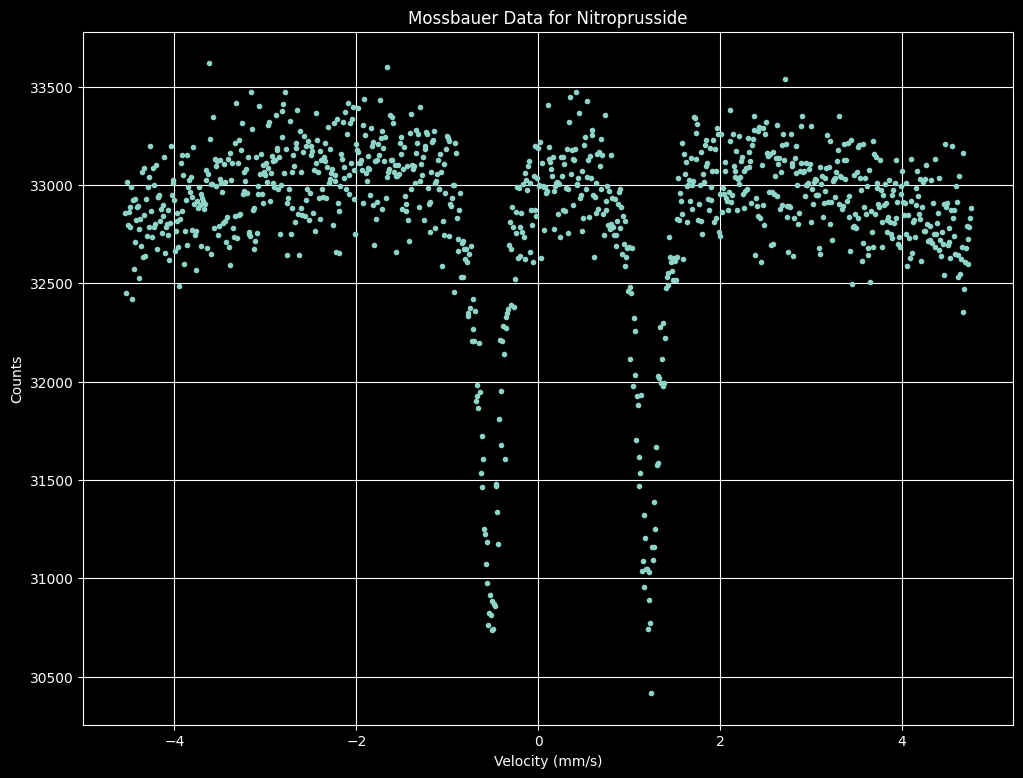

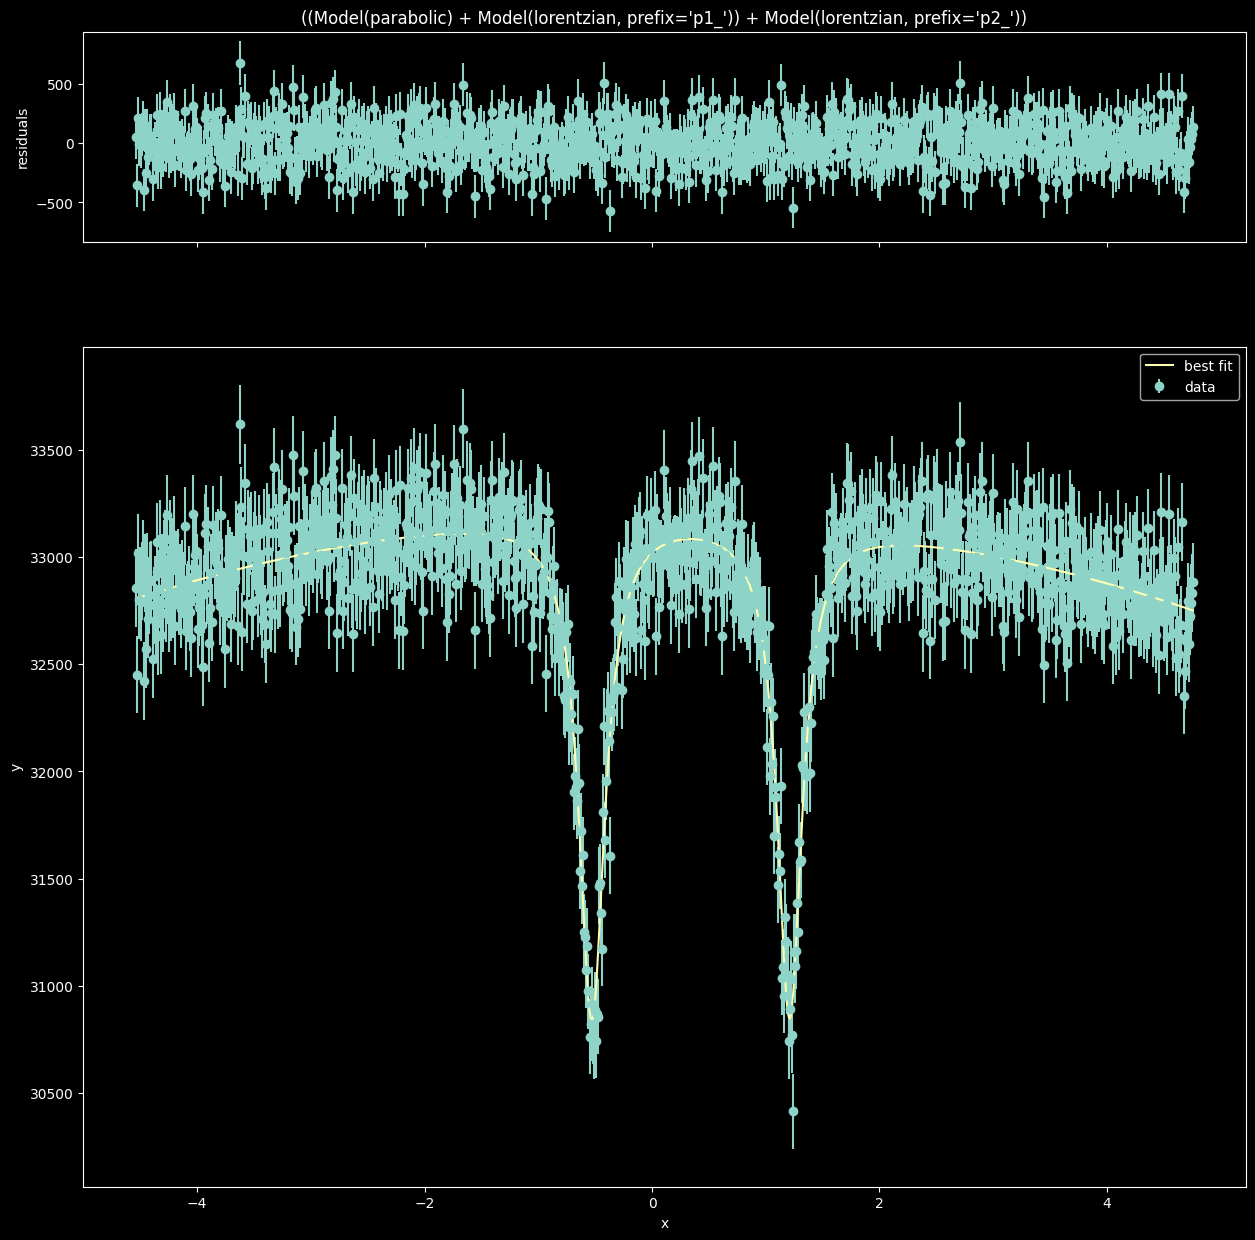

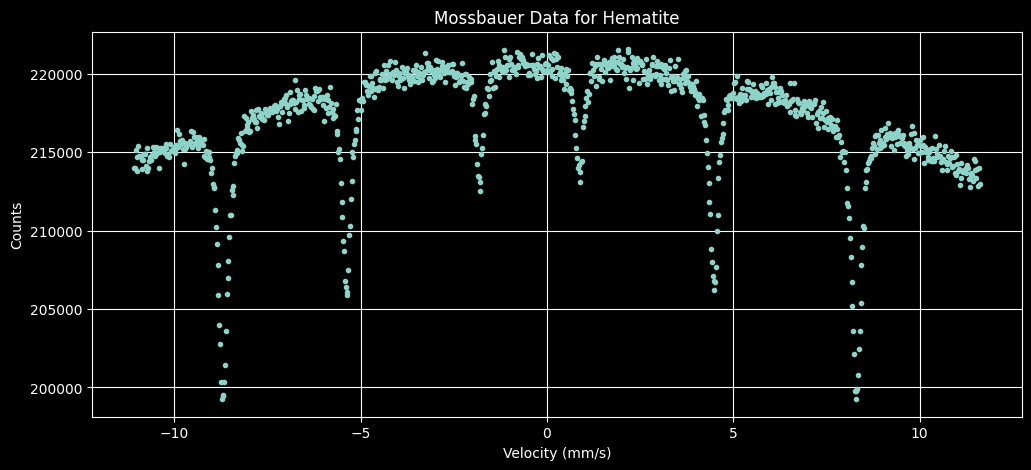

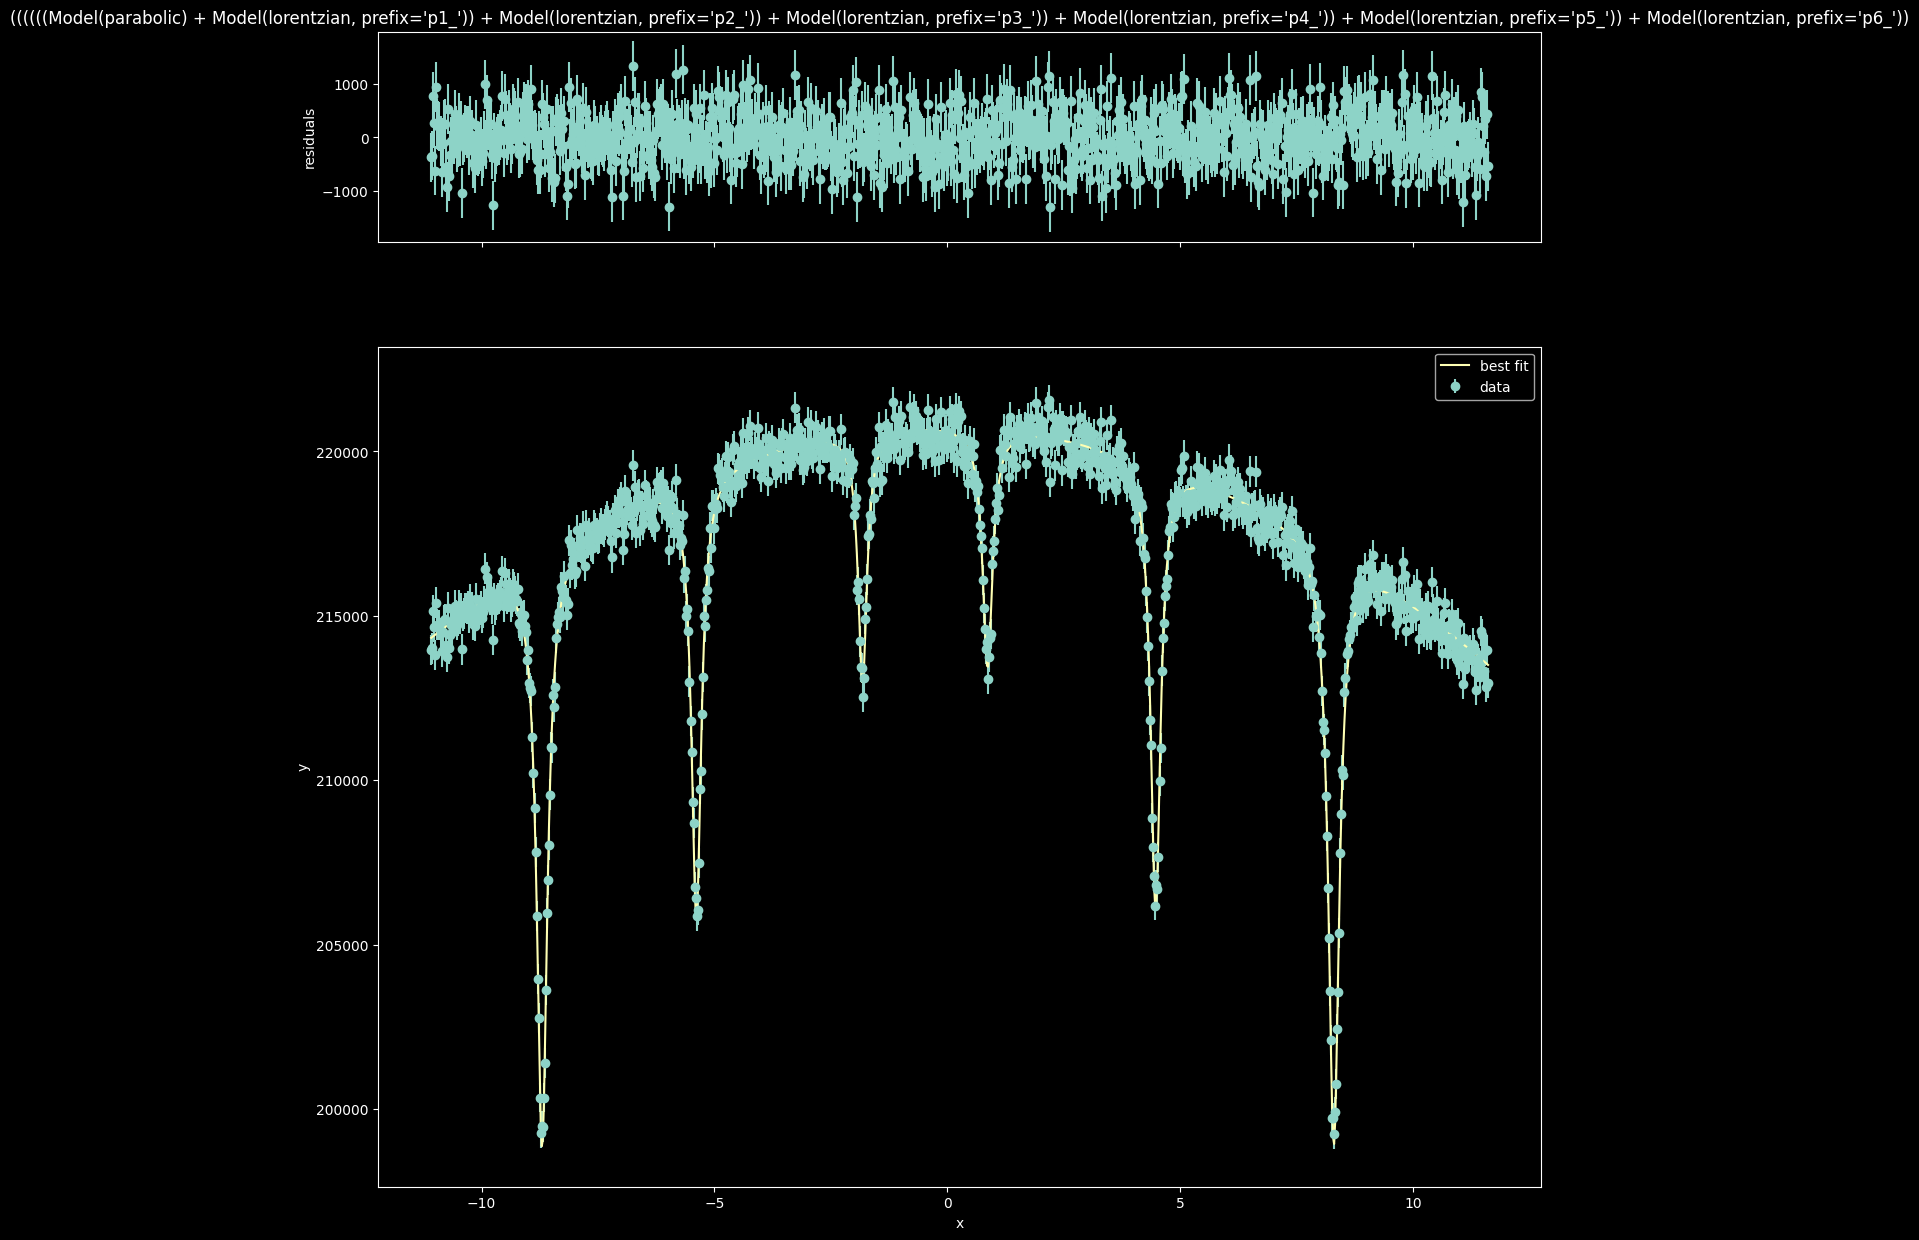

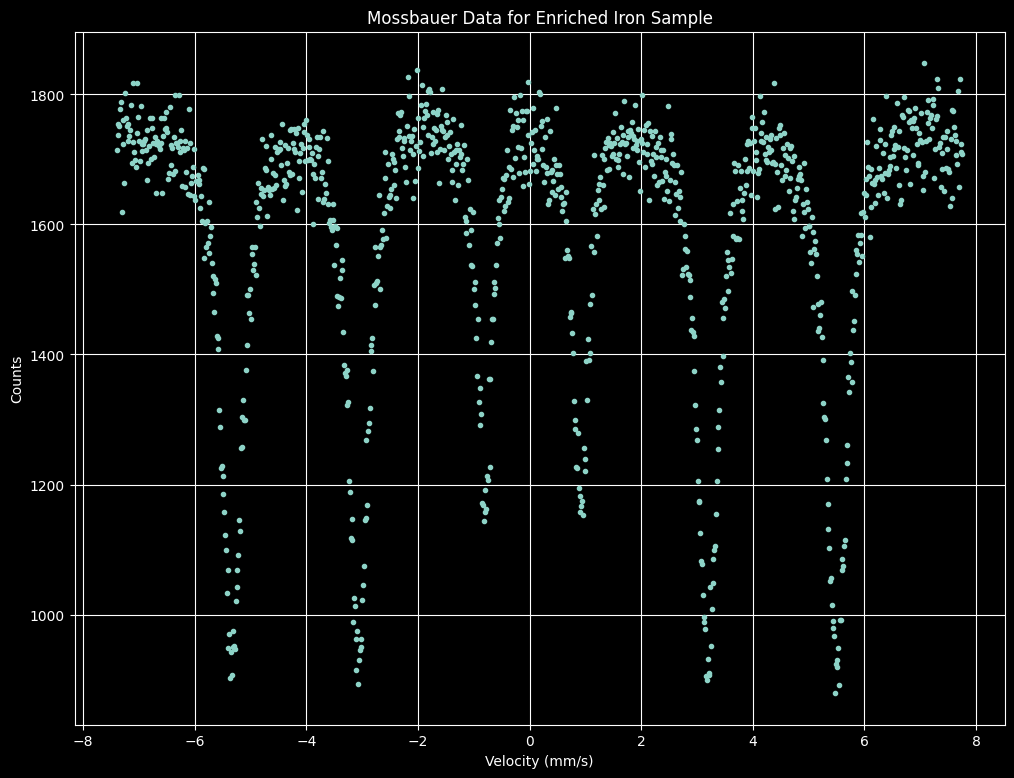

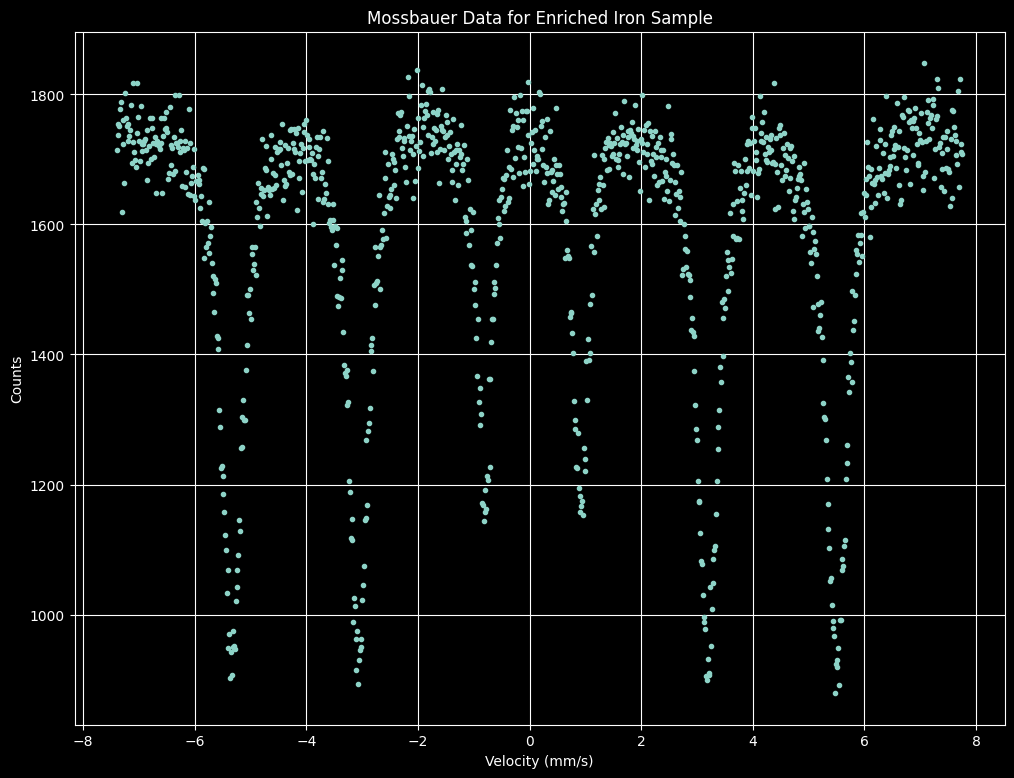

In [171]:
# Create a velocity column, as described above
Fe['velocity'] = velocity_cal(Fe['Chan'],Vpp['Fe'])

# Sanity plot
myfig = plt.figure(figsize=(12,9))
plt.grid()
plt.xlabel(r'Velocity (mm/s)')
plt.ylabel(r'Counts')
plt.title('Mossbauer Data for Enriched Iron Sample')
plt.plot(Fe['velocity'],Fe['Counts'],'.');

plt.savefig("./output/fenofit")



Next, plot against the column index to be able to esitmate a slice.  Take the slice and plot it to check. (these plots do not need to have axis labels, or be particularly big.)

You will also want to plot against the velocity array in order to estimate the fitting parameter start values.

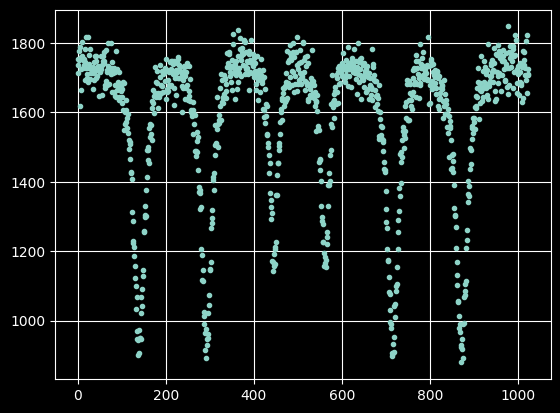

In [172]:
plt.grid()
plt.plot(Fe['Counts'],'.');

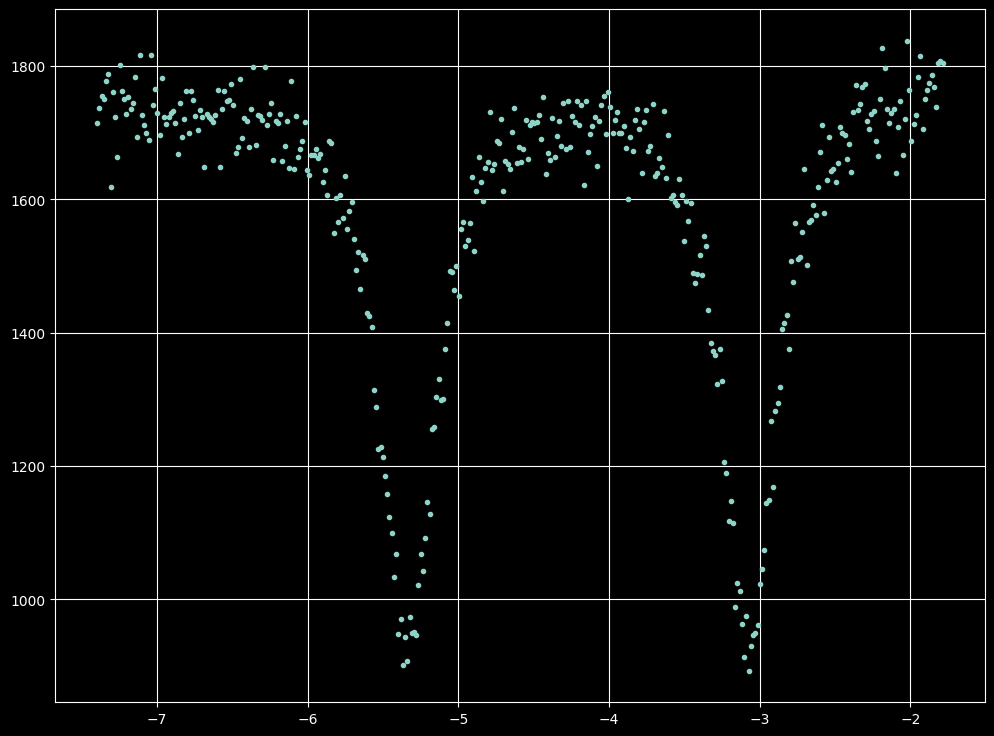

In [173]:
# %matplotlib widget
Index = list(range(0,380)) # FIRST SLICE

myfig = plt.figure(figsize=(12,9))
plt.grid()
plt.plot(Fe['velocity'][Index],Fe['Counts'][Index],'.');

### Fit the slice to the model

Now you should be reday to apply the procedure described in the **Composite Model Demo - Mossbauer** notebook.

Below is a reminder of the basic steps.

### Make the model

The model fit will consist of two Lorentzian peaks and a quadratic background.

The background fuction has the form
$$f(x;a,b,c) = ax^2 + bx + c\;.$$

The Lorentzian lineshape has the form
$$f(x;A,\mu,\sigma) = \frac{A}{\pi}\left[\frac{\sigma}{(x-\mu)^2 + \sigma^2}\right]\;.$$ 

Note that the height of the peak at the center ($x=\mu$) is equal to $\frac{A}{\pi\sigma}$ and that the full-width at half-maximum is $2\sigma$.

In [174]:
# Import a gaussian peak and second order polynomial for background

from lmfit.models import QuadraticModel, LorentzianModel

# create an instance of the model
# Note use of prefixes to keep parameters separate
model1 = QuadraticModel() + LorentzianModel(prefix='p1_') + LorentzianModel(prefix='p2_')

model = model1

params = model.make_params()

print('parameter names: {}'.format(model.param_names))

parameter names: ['a', 'b', 'c', 'p1_amplitude', 'p1_center', 'p1_sigma', 'p2_amplitude', 'p2_center', 'p2_sigma']


### Set the fit parameter starting points

The first peak is shown as an example.

In [175]:
params['p1_center'].set(value=-5.361, vary=True)
params['p1_amplitude'].set(value=-700.0*.15*np.pi, vary=True)
valSigma = .15
print(valSigma)
params['p1_sigma'].set(value=valSigma, vary=True)


params['p2_center'].set(value=-3, vary=True)
params['p2_amplitude'].set(value=-720.0*.15*np.pi, vary=True)
valSigma = .15
print(valSigma)
params['p2_sigma'].set(value=valSigma, vary=True)

0.15
0.15


Then fit.  The code below is an example.  Note the use of wieghts from Poisson statistics of counting and also the commands to resize the plot from the fitting routine.

[[Model]]
    ((Model(parabolic) + Model(lorentzian, prefix='p1_')) + Model(lorentzian, prefix='p2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 380
    # variables        = 9
    chi-square         = 333.958420
    reduced chi-square = 0.90015747
    Akaike info crit   = -31.0788081
    Bayesian info crit = 4.38273319
    R-squared          = 0.97355586
[[Variables]]
    a:            -0.12951470 +/- 1.06626658 (823.28%) (init = 0)
    b:             5.43603042 +/- 9.97906492 (183.57%) (init = 0)
    c:             1796.46049 +/- 20.3038716 (1.13%) (init = 0)
    p1_amplitude: -571.408596 +/- 12.6670359 (2.22%) (init = -329.8672)
    p1_center:    -5.33625054 +/- 0.00255227 (0.05%) (init = -5.361)
    p1_sigma:      0.21796965 +/- 0.00493910 (2.27%) (init = 0.15)
    p2_amplitude: -570.439959 +/- 12.5039140 (2.19%) (init = -339.292)
    p2_center:    -3.07192217 +/- 0.00253578 (0.08%) (init = -3)
    p2_sigma:      0.21442

/home/coyotedark/Documents/uw/phys/431/mossbauer-spectroscopy-main/.venv/lib/python3.13/site-packages/uncertainties/core.py:526: FutureWarning: AffineScalarFunc.error_components() is currently an instance method. This method is deprecated. In a future release it will be replaced with an instance property by the same name. It will be accessed by AffineScalarFunc.error_components (with no parentheses).
  return float(sqrt(sum(delta**2 for delta in self.error_components().values())))
/home/coyotedark/Documents/uw/phys/431/mossbauer-spectroscopy-main/.venv/lib/python3.13/site-packages/uncertainties/core.py:491: FutureWarning: AffineScalarFunc.derivatives() is deprecated. It will be removed in a future release.
  for variable, derivative in self.derivatives.items():


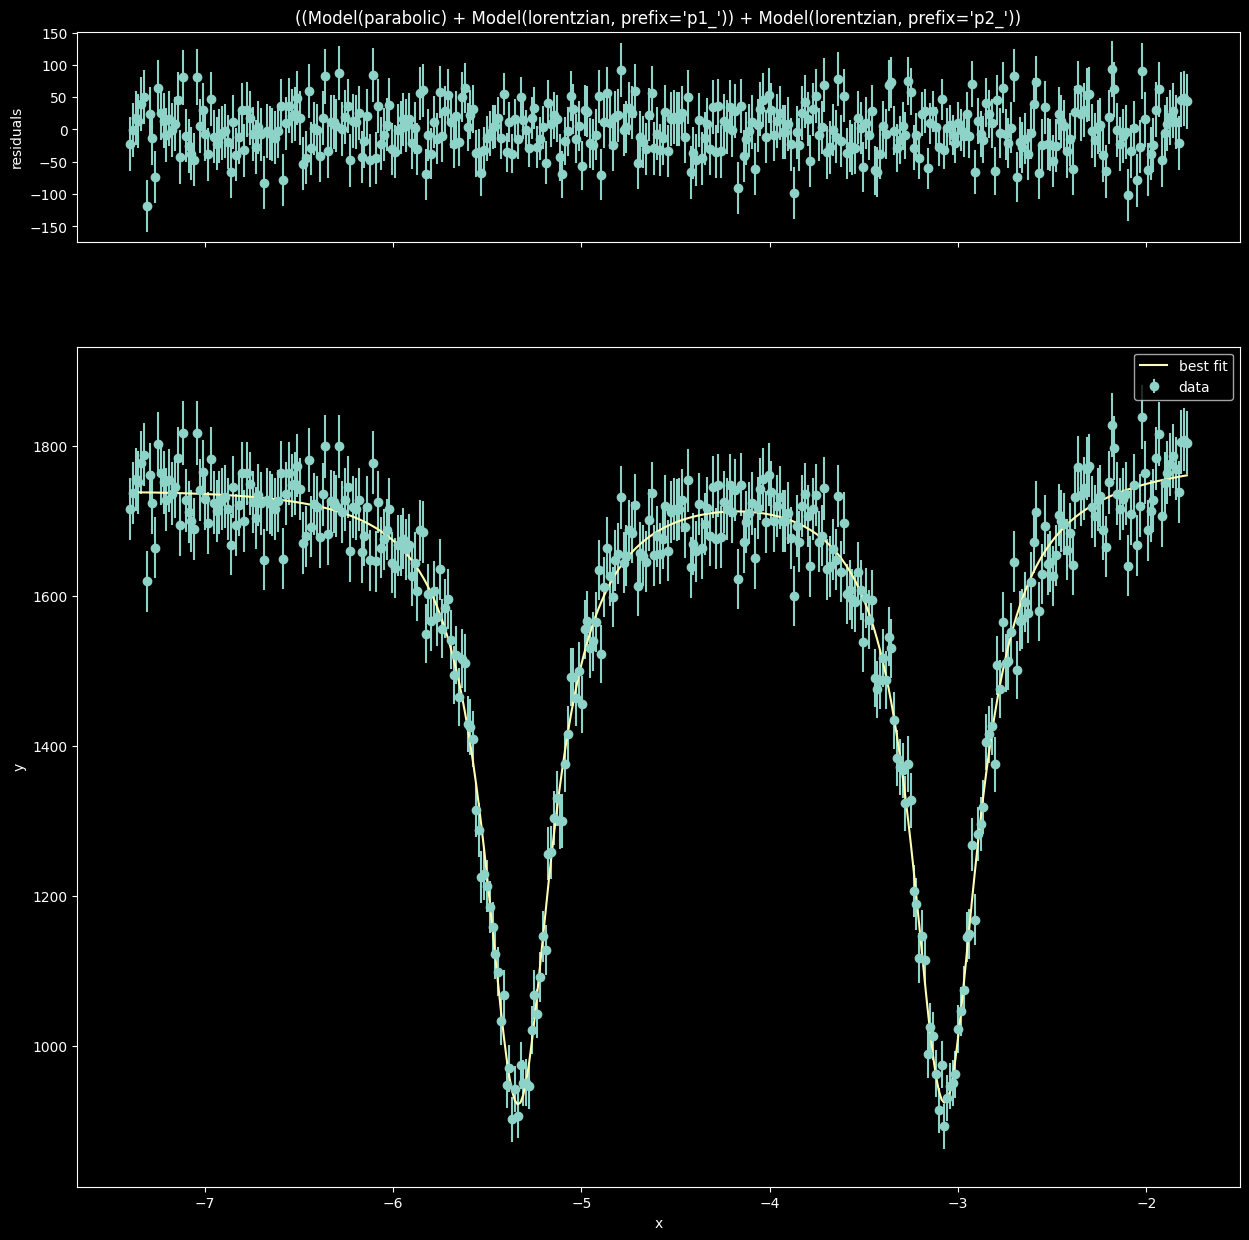

In [176]:
model_fit = model.fit(Fe['Counts'][Index], params, x=Fe['velocity'], weights=1/np.sqrt(Fe['Counts'][Index]))

print(model_fit.fit_report(show_correl=False))


myfig=plt.figure(figsize=(15,15))
model_fit.plot(fig=myfig);

#### Have you succeeded with the above?

If not,  try to fix it before mving on. If so, do the following:
1. Save your current parameters
2. Then
   * Add another peak by expanding your slice or
   * Choose a different slice and fit the peaks there
3. Save your parameters and repeat.

Your goal is to get good values of the peak locations.

(When I did it, I added peaks, two at a time, until I got a fit for the whole scan.)

parameter names: ['a', 'b', 'c', 'p1_amplitude', 'p1_center', 'p1_sigma', 'p2_amplitude', 'p2_center', 'p2_sigma']
0.15
0.15


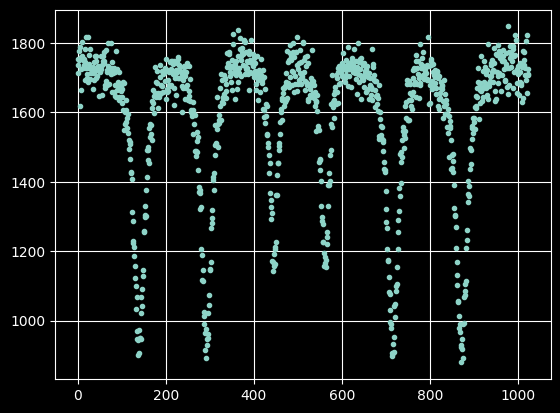

In [177]:
# Next Slice 0-680

## Find the Slice
# %matplotlib widget
%matplotlib inline
plt.grid()
plt.plot(Fe['Counts'],'.');

Index = list(range(0,680)) # NOTE HERE

# myfig = plt.figure(figsize=(12,9))
# plt.grid()
# plt.plot(Fe['velocity'][Index],Fe['Counts'][Index],'.');

print('parameter names: {}'.format(model.param_names))

## Fit the curve

model2 = LorentzianModel(prefix='p3_') + LorentzianModel(prefix='p4_')
model = model1 + model2


params = model.make_params()
### From the first one:
params['p1_center'].set(value=-5.361, vary=True)
params['p1_amplitude'].set(value=-700.0*.15*np.pi, vary=True)
valSigma = .15
print(valSigma)
params['p1_sigma'].set(value=valSigma, vary=True)


params['p2_center'].set(value=-3, vary=True)
params['p2_amplitude'].set(value=-720.0*.15*np.pi, vary=True)
valSigma = .15
print(valSigma)
params['p2_sigma'].set(value=valSigma, vary=True)


### The parameters needed for the next 2
params['p3_center'].set(value=-0.834, vary=True)
params['p3_amplitude'].set(value=-450.0*.15*np.pi, vary=True)
params['p3_sigma'].set(value=valSigma, vary=True)


params['p4_center'].set(value=.91, vary=True)
params['p4_amplitude'].set(value=-450.0*.15*np.pi, vary=True)
params['p4_sigma'].set(value=valSigma, vary=True)




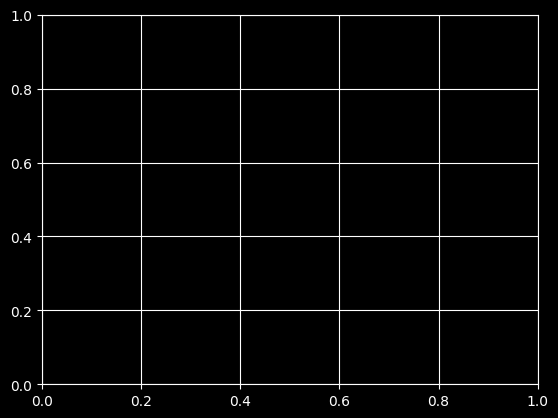

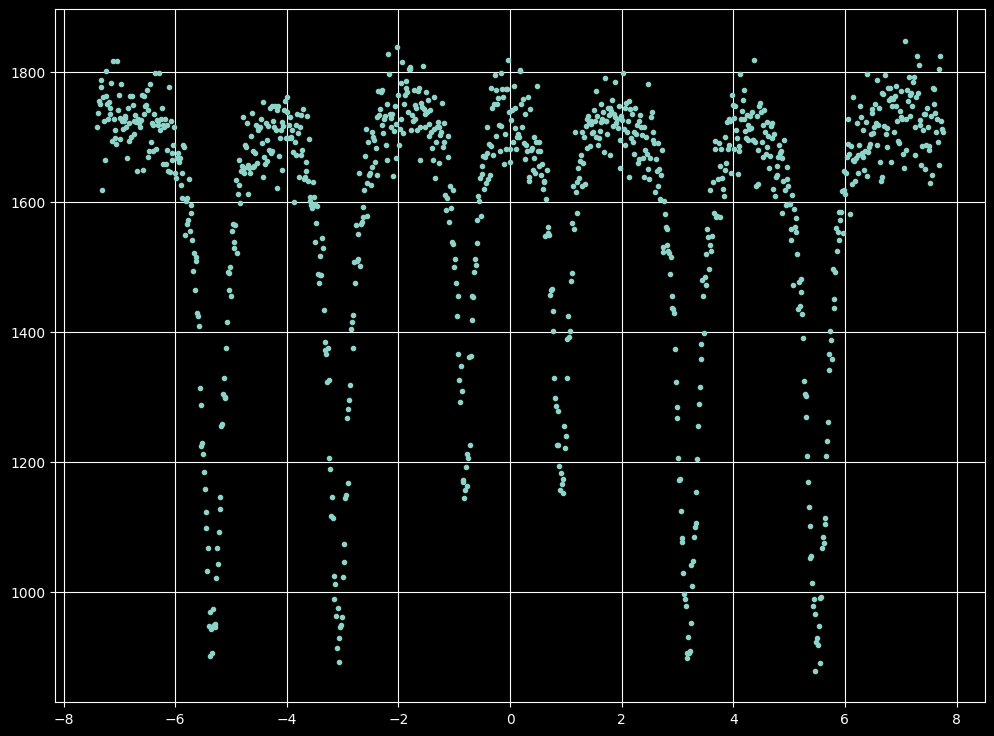

In [178]:
## Last one hopefully?

## Find the Slice
# %matplotlib widget
# %matplotlib inline
plt.grid()
# plt.plot(Fe['Counts'],'.');

Index = list(range(0,len(Fe)))

myfig = plt.figure(figsize=(12,9))
plt.grid()
plt.plot(Fe['velocity'][Index],Fe['Counts'][Index],'.');



In [179]:
## Fit the curve

model3 = LorentzianModel(prefix='p5_') + LorentzianModel(prefix='p6_')
model = model1 + model2 + model3

params = model.make_params()

### From the first one:
params['p1_center'].set(value=-5.361, vary=True)
params['p1_amplitude'].set(value=-700.0*.15*np.pi, vary=True)
valSigma = .15
print(valSigma)
params['p1_sigma'].set(value=valSigma, vary=True)


params['p2_center'].set(value=-3, vary=True)
params['p2_amplitude'].set(value=-720.0*.15*np.pi, vary=True)
valSigma = .15
print(valSigma)
params['p2_sigma'].set(value=valSigma, vary=True)


### The parameters from the second slice
params['p3_center'].set(value=-0.834, vary=True)
params['p3_amplitude'].set(value=-450.0*.15*np.pi, vary=True)
params['p3_sigma'].set(value=valSigma, vary=True)


params['p4_center'].set(value=.91, vary=True)
params['p4_amplitude'].set(value=-450.0*.15*np.pi, vary=True)
params['p4_sigma'].set(value=valSigma, vary=True)


### The parameters from the final slice
params['p5_center'].set(value=3.2, vary=True)
params['p5_amplitude'].set(value=-350.0*.15*np.pi, vary=True)
params['p5_sigma'].set(value=valSigma, vary=True)


params['p6_center'].set(value=5.6, vary=True)
params['p6_amplitude'].set(value=-400.0*.15*np.pi, vary=True)
params['p6_sigma'].set(value=valSigma, vary=True)

0.15
0.15


[[Model]]
    ((((Model(parabolic) + Model(lorentzian, prefix='p1_')) + Model(lorentzian, prefix='p2_')) + (Model(lorentzian, prefix='p3_') + Model(lorentzian, prefix='p4_'))) + (Model(lorentzian, prefix='p5_') + Model(lorentzian, prefix='p6_')))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 137
    # data points      = 1024
    # variables        = 21
    chi-square         = 934.135595
    reduced chi-square = 0.93134157
    Akaike info crit   = -52.0546061
    Bayesian info crit = 51.5063018
    R-squared          = 0.96911242
[[Variables]]
    a:            -0.69396131 +/- 0.10117085 (14.58%) (init = 0)
    b:            -0.07007302 +/- 0.42030451 (599.81%) (init = 0)
    c:             1787.05288 +/- 3.66593446 (0.21%) (init = 0)
    p1_amplitude: -575.204138 +/- 10.2395071 (1.78%) (init = -329.8672)
    p1_center:    -5.33623887 +/- 0.00258576 (0.05%) (init = -5.361)
    p1_sigma:      0.21907236 +/- 0.00445798 (2.03%) (init = 0.15)
    p2_amplitude

/home/coyotedark/Documents/uw/phys/431/mossbauer-spectroscopy-main/.venv/lib/python3.13/site-packages/uncertainties/core.py:526: FutureWarning: AffineScalarFunc.error_components() is currently an instance method. This method is deprecated. In a future release it will be replaced with an instance property by the same name. It will be accessed by AffineScalarFunc.error_components (with no parentheses).
  return float(sqrt(sum(delta**2 for delta in self.error_components().values())))
/home/coyotedark/Documents/uw/phys/431/mossbauer-spectroscopy-main/.venv/lib/python3.13/site-packages/uncertainties/core.py:491: FutureWarning: AffineScalarFunc.derivatives() is deprecated. It will be removed in a future release.
  for variable, derivative in self.derivatives.items():


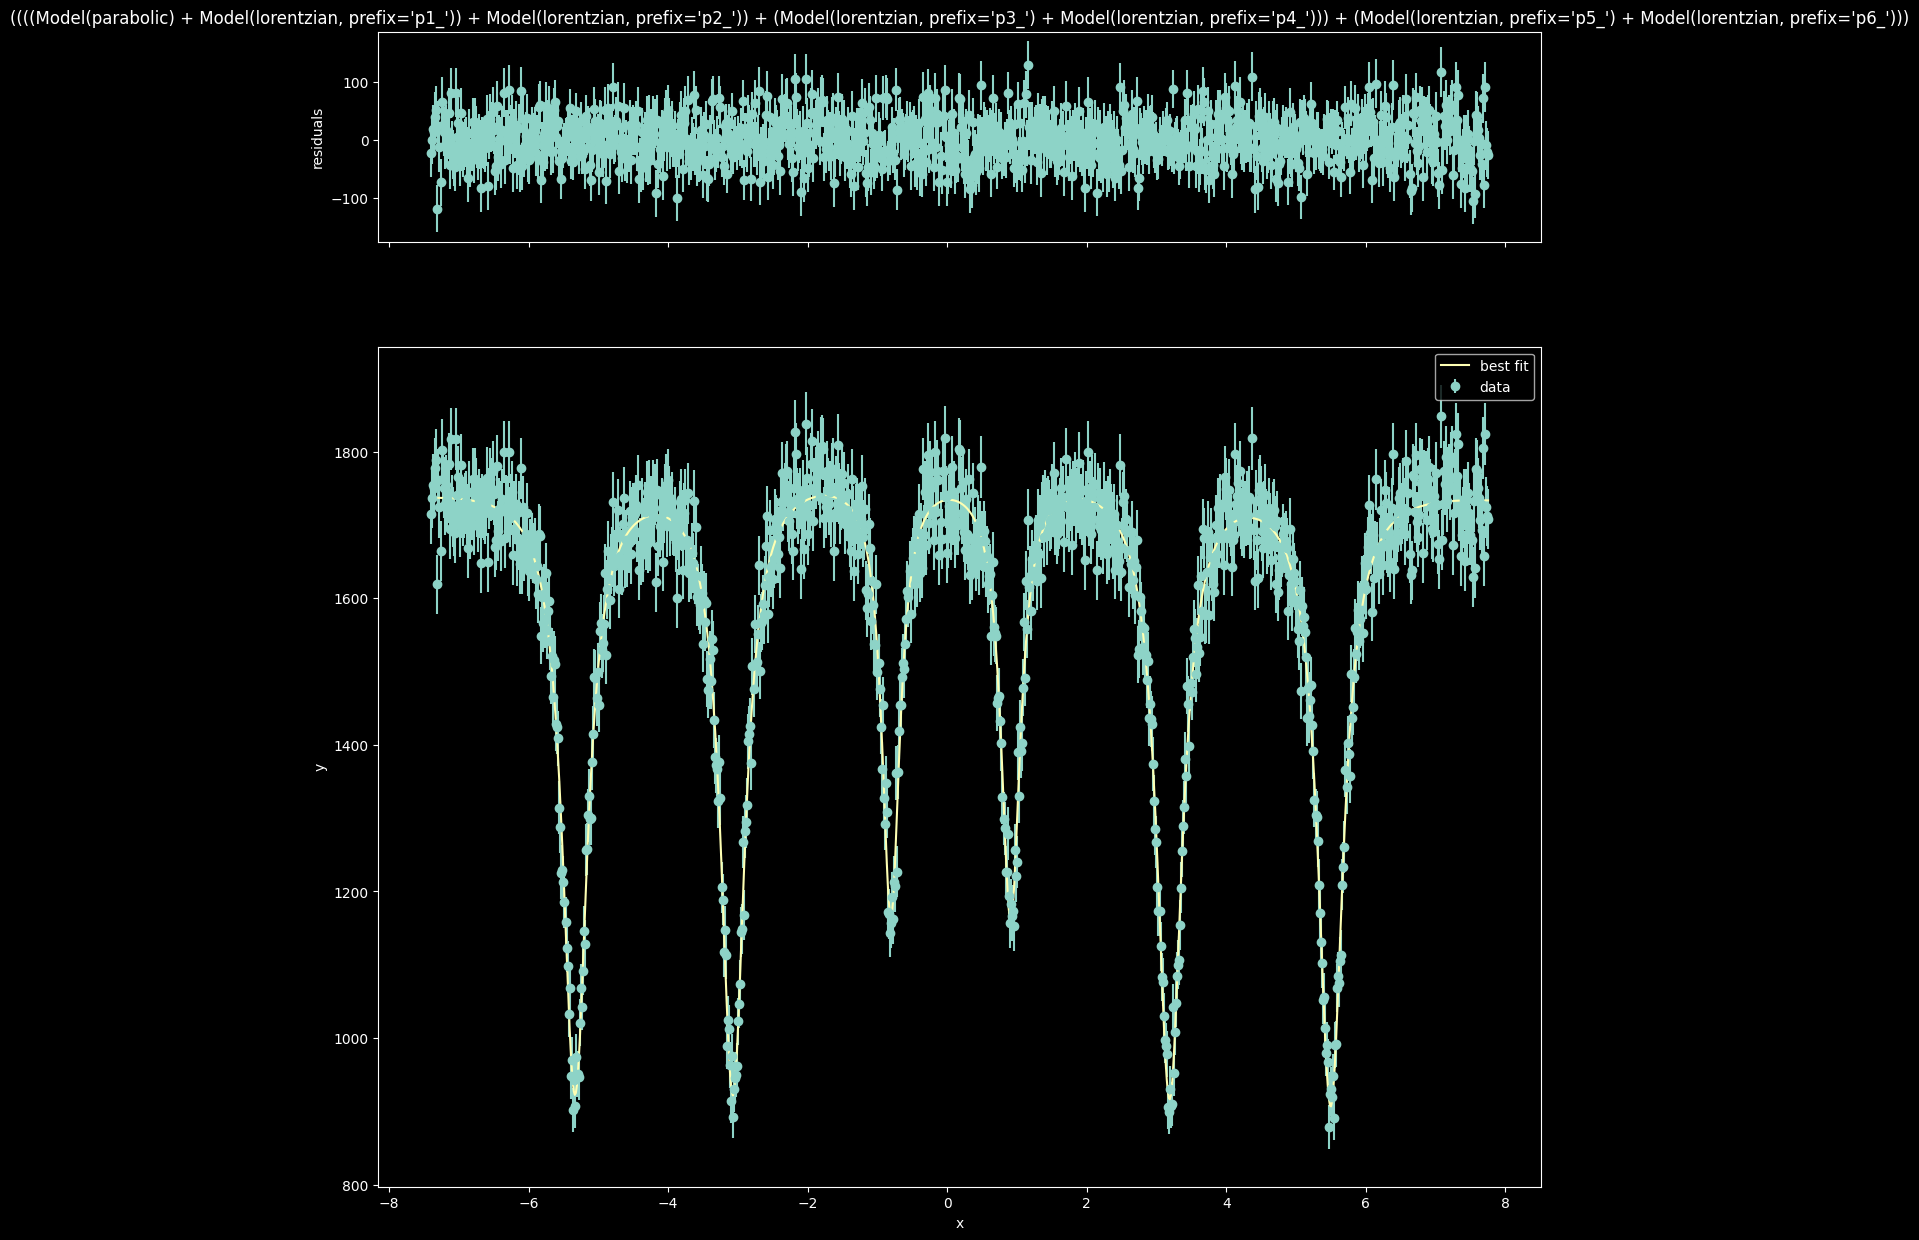

In [180]:

## Eventually the fitting:
model_fit = model.fit(Fe['Counts'][Index], params, x=Fe['velocity'], weights=1/np.sqrt(Fe['Counts'][Index]))

print(model_fit.fit_report(show_correl=False))

myfig=plt.figure(figsize=(15,15))
model_fit.plot(fig=myfig)
plt.savefig("output.png")

In [181]:
Index = list(range(0,len(Fe)))

model_fit = model.fit(Fe['Counts'][Index], params, x=Fe['velocity'], weights=1/np.sqrt(Fe['Counts'][Index]))

print(model_fit.fit_report(show_correl=False))

[[Model]]
    ((((Model(parabolic) + Model(lorentzian, prefix='p1_')) + Model(lorentzian, prefix='p2_')) + (Model(lorentzian, prefix='p3_') + Model(lorentzian, prefix='p4_'))) + (Model(lorentzian, prefix='p5_') + Model(lorentzian, prefix='p6_')))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 137
    # data points      = 1024
    # variables        = 21
    chi-square         = 934.135595
    reduced chi-square = 0.93134157
    Akaike info crit   = -52.0546061
    Bayesian info crit = 51.5063018
    R-squared          = 0.96911242
[[Variables]]
    a:            -0.69396131 +/- 0.10117085 (14.58%) (init = 0)
    b:            -0.07007302 +/- 0.42030451 (599.81%) (init = 0)
    c:             1787.05288 +/- 3.66593446 (0.21%) (init = 0)
    p1_amplitude: -575.204138 +/- 10.2395071 (1.78%) (init = -329.8672)
    p1_center:    -5.33623887 +/- 0.00258576 (0.05%) (init = -5.361)
    p1_sigma:      0.21907236 +/- 0.00445798 (2.03%) (init = 0.15)
    p2_amplitude

/home/coyotedark/Documents/uw/phys/431/mossbauer-spectroscopy-main/.venv/lib/python3.13/site-packages/uncertainties/core.py:526: FutureWarning: AffineScalarFunc.error_components() is currently an instance method. This method is deprecated. In a future release it will be replaced with an instance property by the same name. It will be accessed by AffineScalarFunc.error_components (with no parentheses).
  return float(sqrt(sum(delta**2 for delta in self.error_components().values())))
/home/coyotedark/Documents/uw/phys/431/mossbauer-spectroscopy-main/.venv/lib/python3.13/site-packages/uncertainties/core.py:491: FutureWarning: AffineScalarFunc.derivatives() is deprecated. It will be removed in a future release.
  for variable, derivative in self.derivatives.items():


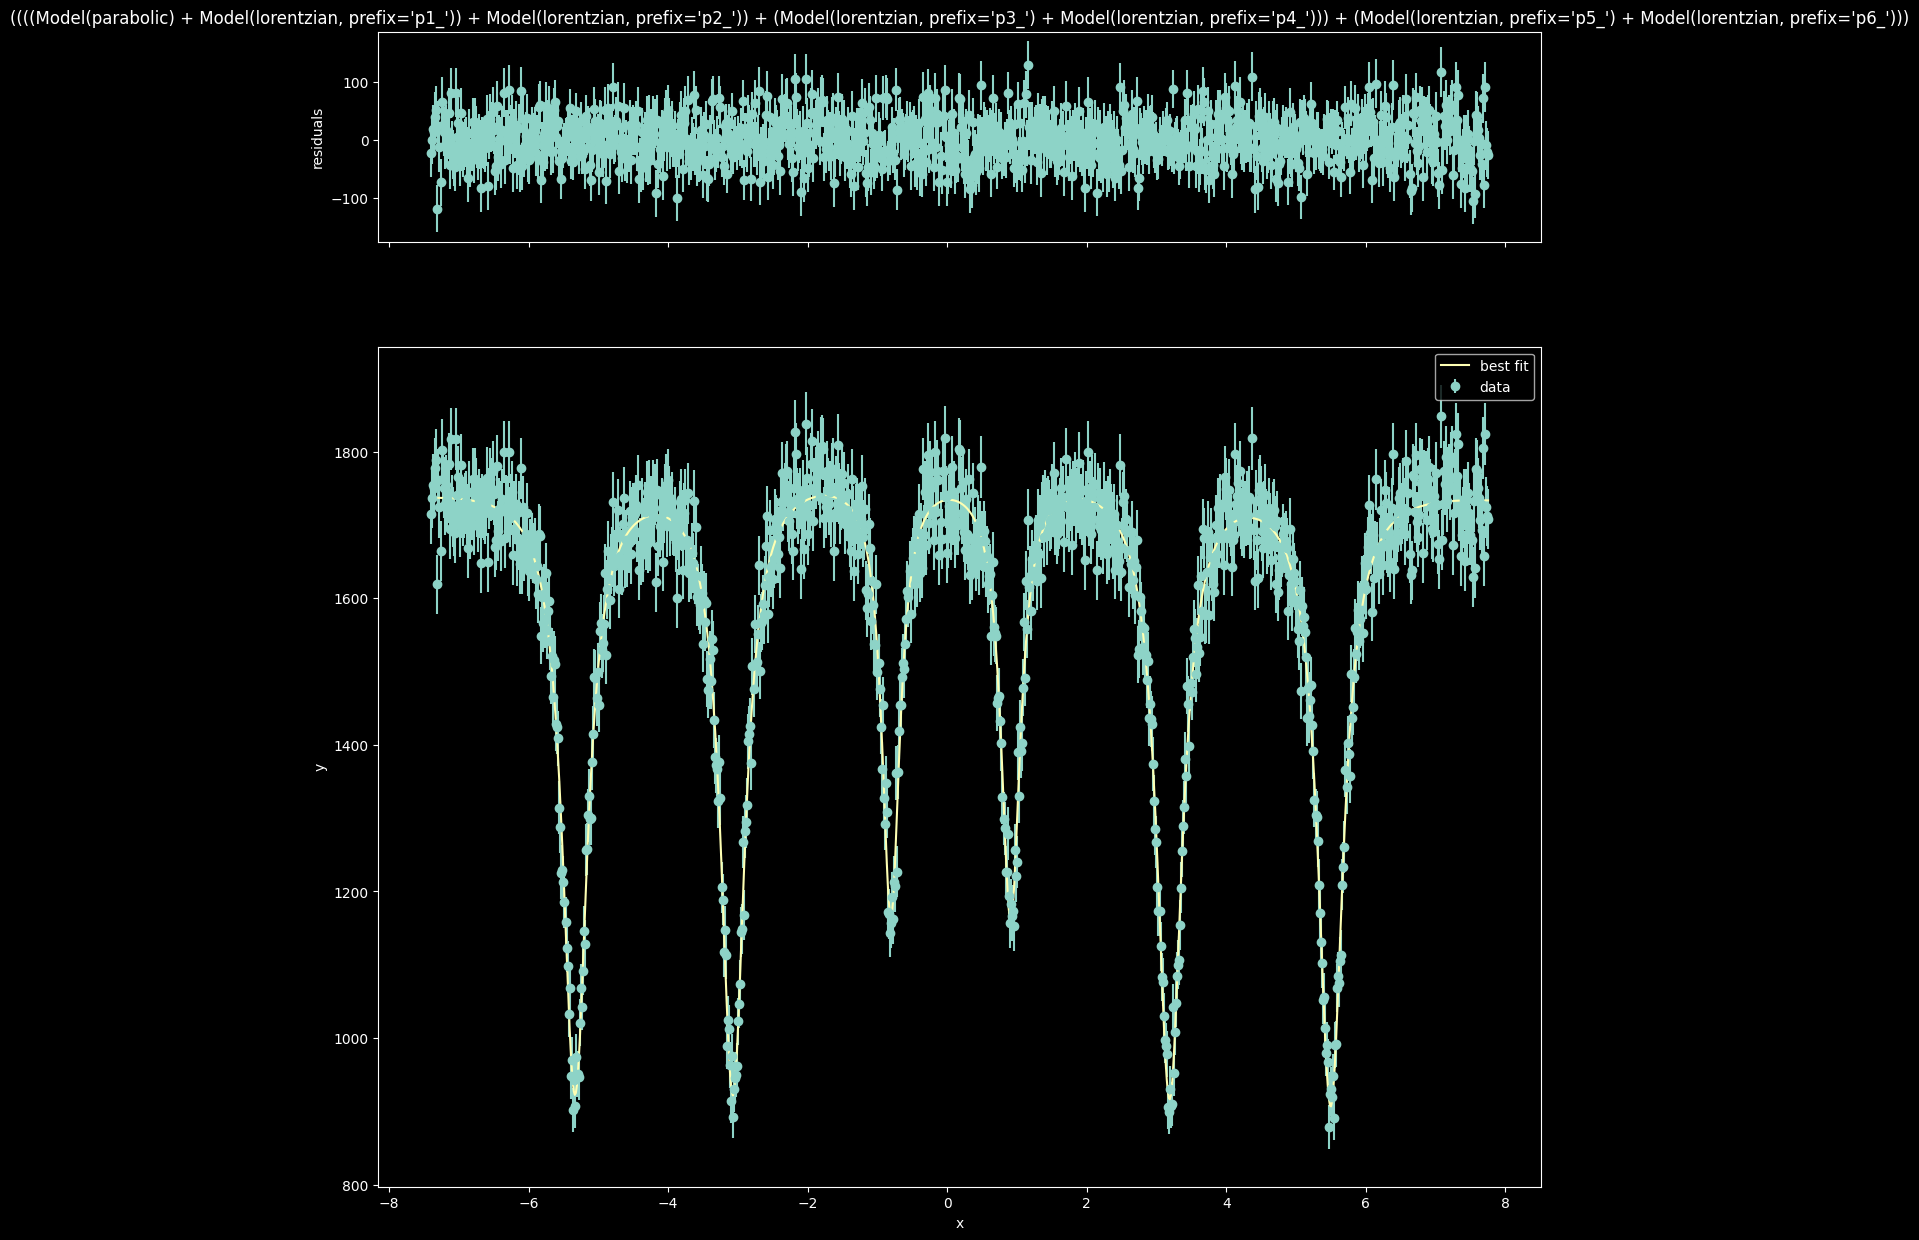

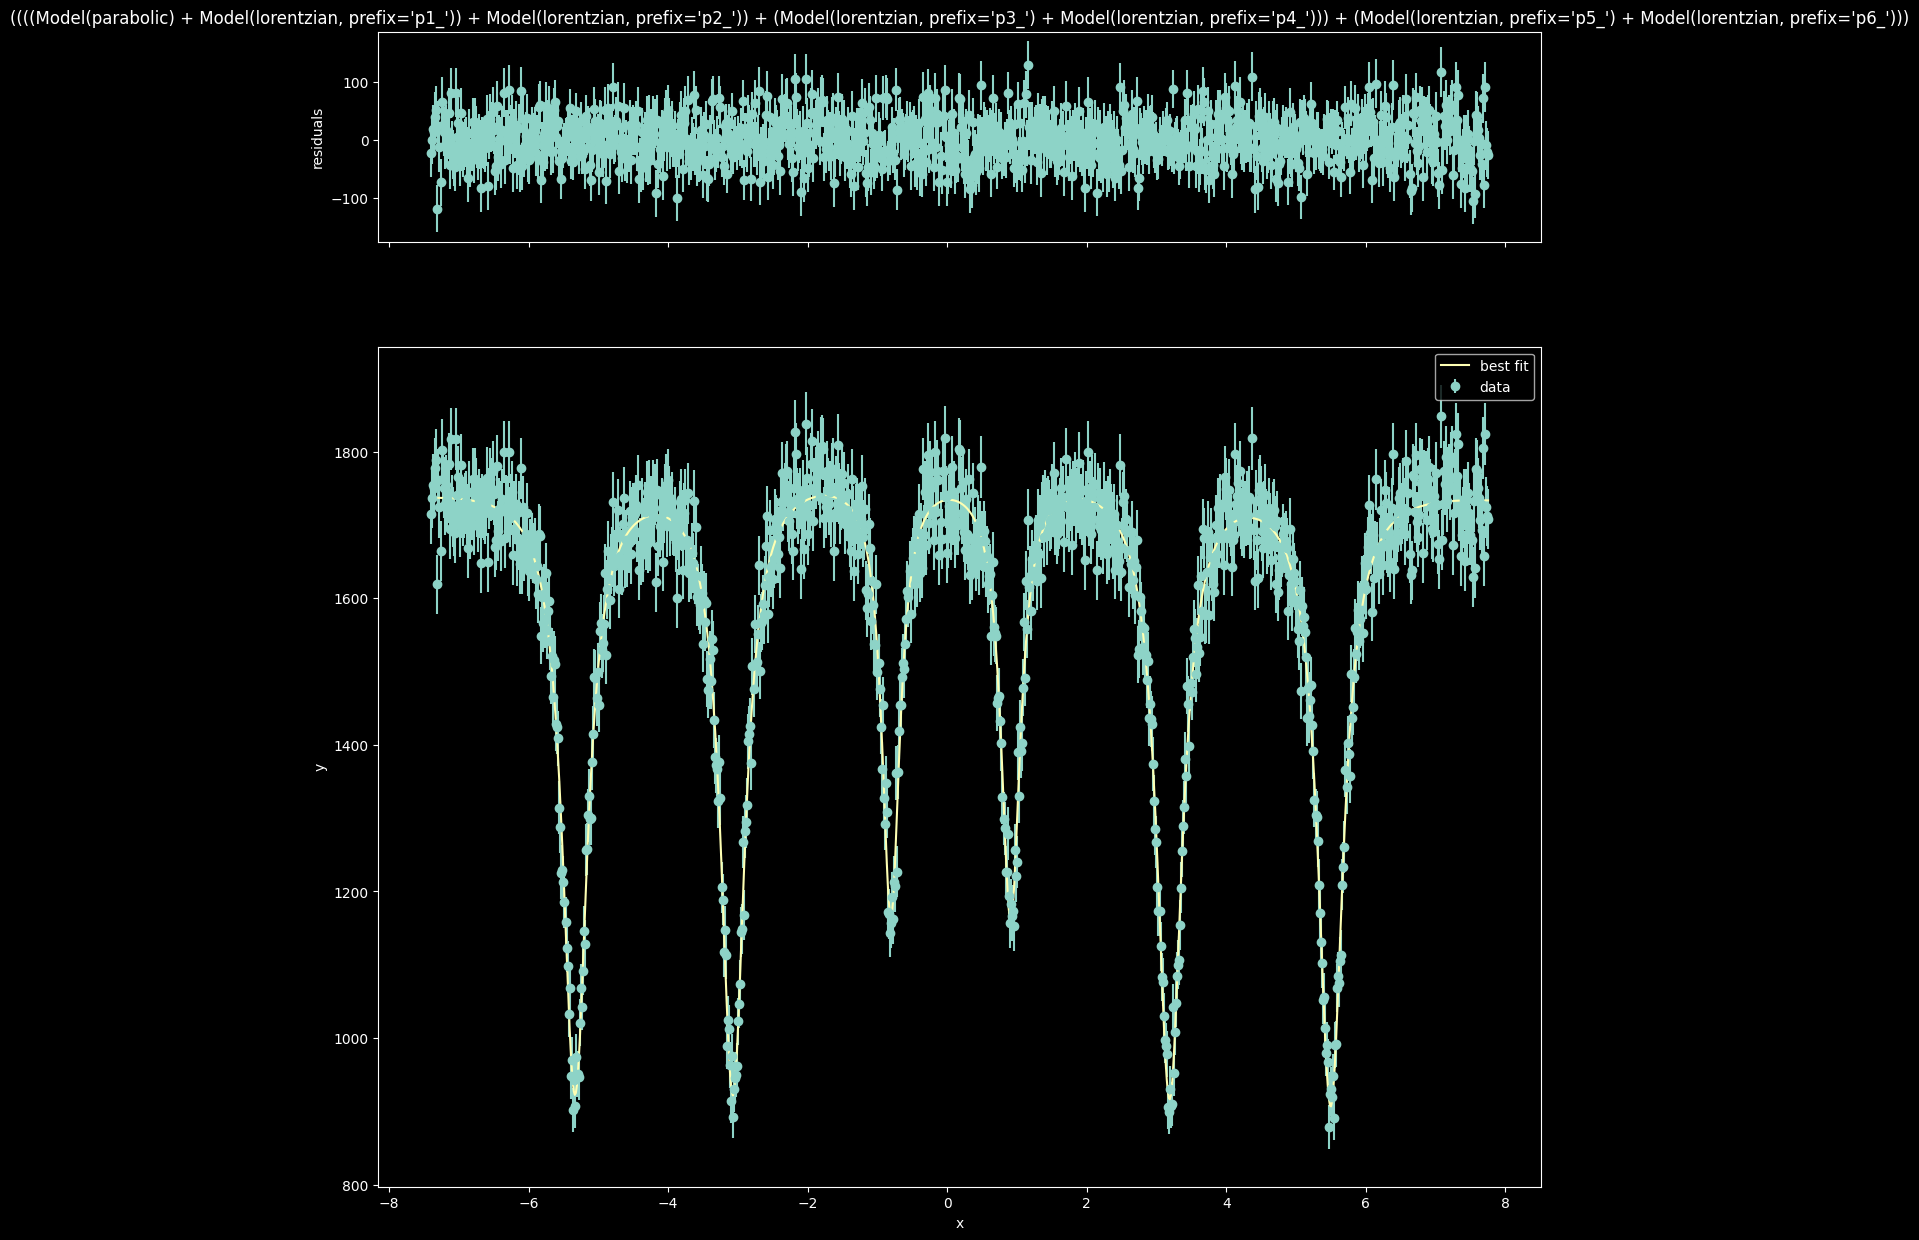

In [182]:

myfig=plt.figure(figsize=(15,15))
model_fit.plot(fig=myfig)

### Save the peak centers

When you have obtained the best values, save the peak parameters.  I like to make a dataframe.  Here is one way to iterate over the parameters after they have been saved to extract the peak locations and uncertainties and make a table.

In [183]:
# Save the parameters from the best fit
Fe_params = model_fit.params

Fe_peaks = []
for parm in Fe_params:
    if parm.endswith('center'): 
        Fe_peaks.append(unc.ufloat(Fe_params[parm].value, Fe_params[parm].stderr))

In [184]:
Fe_peaks_df = pd.DataFrame()
Fe_peaks_df['Number'] = [1,2,3,4,5,6]
Fe_peaks_df['Location (mm/s)'] = Fe_peaks
Fe_peaks_df

,Number,Location (mm/s)
0,1,-5.3362+/-0.0026
1,2,-3.0727+/-0.0025
2,3,-0.8075+/-0.0032
3,4,0.9100+/-0.0033
4,5,3.1873+/-0.0026
5,6,5.4964+/-0.0026


## Repeat the above procedure for the other data files.

Remember: your goal here is a list of the best-fit peak locations in mm/s units for each data run.

## Nitroprusside Analysis:

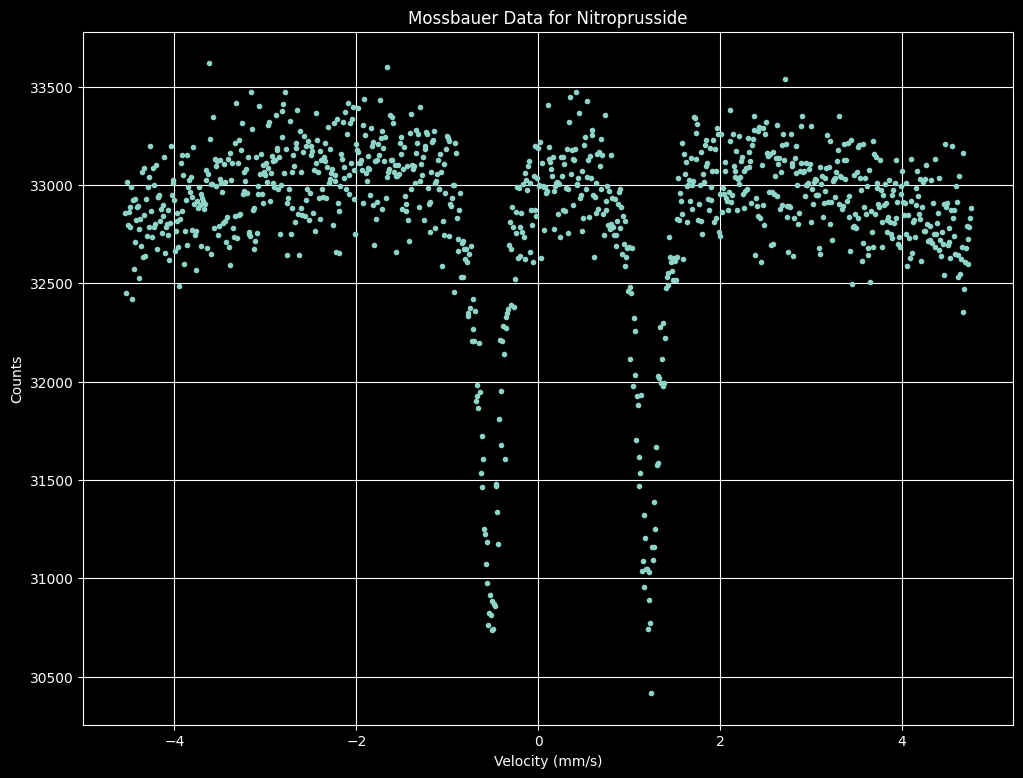

In [185]:
## Add as many cells as you need.

# First we read
prus = pd.read_csv('./Data Collected/nitroprusside_30.80mV.tsv',header=0,names=['Chan','Counts'],sep='\t')
prus['velocity'] = velocity_cal(prus['Chan'],Vpp['Nitroprusside'])

# Next, we create a sanity/peakfinding plot (using widget to find the values if needed)
# %matplotlib widget

myfig = plt.figure(figsize=(12,9))
plt.grid()
plt.xlabel(r'Velocity (mm/s)')
plt.ylabel(r'Counts')
plt.title('Mossbauer Data for Nitroprusside')
plt.plot(prus['velocity'],prus['Counts'],'.');
plt.savefig("output/nitroprussidenofit.png")


Parameters([('a', <Parameter 'a', value=0.0, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=0.0, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=0.0, bounds=[-inf:inf]>), ('p1_amplitude', <Parameter 'p1_amplitude', value=0.0, bounds=[-inf:inf]>), ('p1_center', <Parameter 'p1_center', value=0.0, bounds=[-inf:inf]>), ('p1_sigma', <Parameter 'p1_sigma', value=0.0, bounds=[0:inf]>), ('p2_amplitude', <Parameter 'p2_amplitude', value=0.0, bounds=[-inf:inf]>), ('p2_center', <Parameter 'p2_center', value=0.0, bounds=[-inf:inf]>), ('p2_sigma', <Parameter 'p2_sigma', value=0.0, bounds=[0:inf]>), ('p1_fwhm', <Parameter 'p1_fwhm', value=0.0, bounds=[-inf:inf], expr='2.0000000*p1_sigma'>), ('p1_height', <Parameter 'p1_height', value=0.0, bounds=[-inf:inf], expr='0.3183099*p1_amplitude/max(1e-15, p1_sigma)'>), ('p2_fwhm', <Parameter 'p2_fwhm', value=0.0, bounds=[-inf:inf], expr='2.0000000*p2_sigma'>), ('p2_height', <Parameter 'p2_height', value=0.0, bounds=[-inf:inf], expr='0.3183099*p2_amplitude

/home/coyotedark/Documents/uw/phys/431/mossbauer-spectroscopy-main/.venv/lib/python3.13/site-packages/uncertainties/core.py:526: FutureWarning: AffineScalarFunc.error_components() is currently an instance method. This method is deprecated. In a future release it will be replaced with an instance property by the same name. It will be accessed by AffineScalarFunc.error_components (with no parentheses).
  return float(sqrt(sum(delta**2 for delta in self.error_components().values())))
/home/coyotedark/Documents/uw/phys/431/mossbauer-spectroscopy-main/.venv/lib/python3.13/site-packages/uncertainties/core.py:491: FutureWarning: AffineScalarFunc.derivatives() is deprecated. It will be removed in a future release.
  for variable, derivative in self.derivatives.items():


,Number,Location (mm/s)
0,1,-0.5292+/-0.0030
1,2,1.2100+/-0.0030


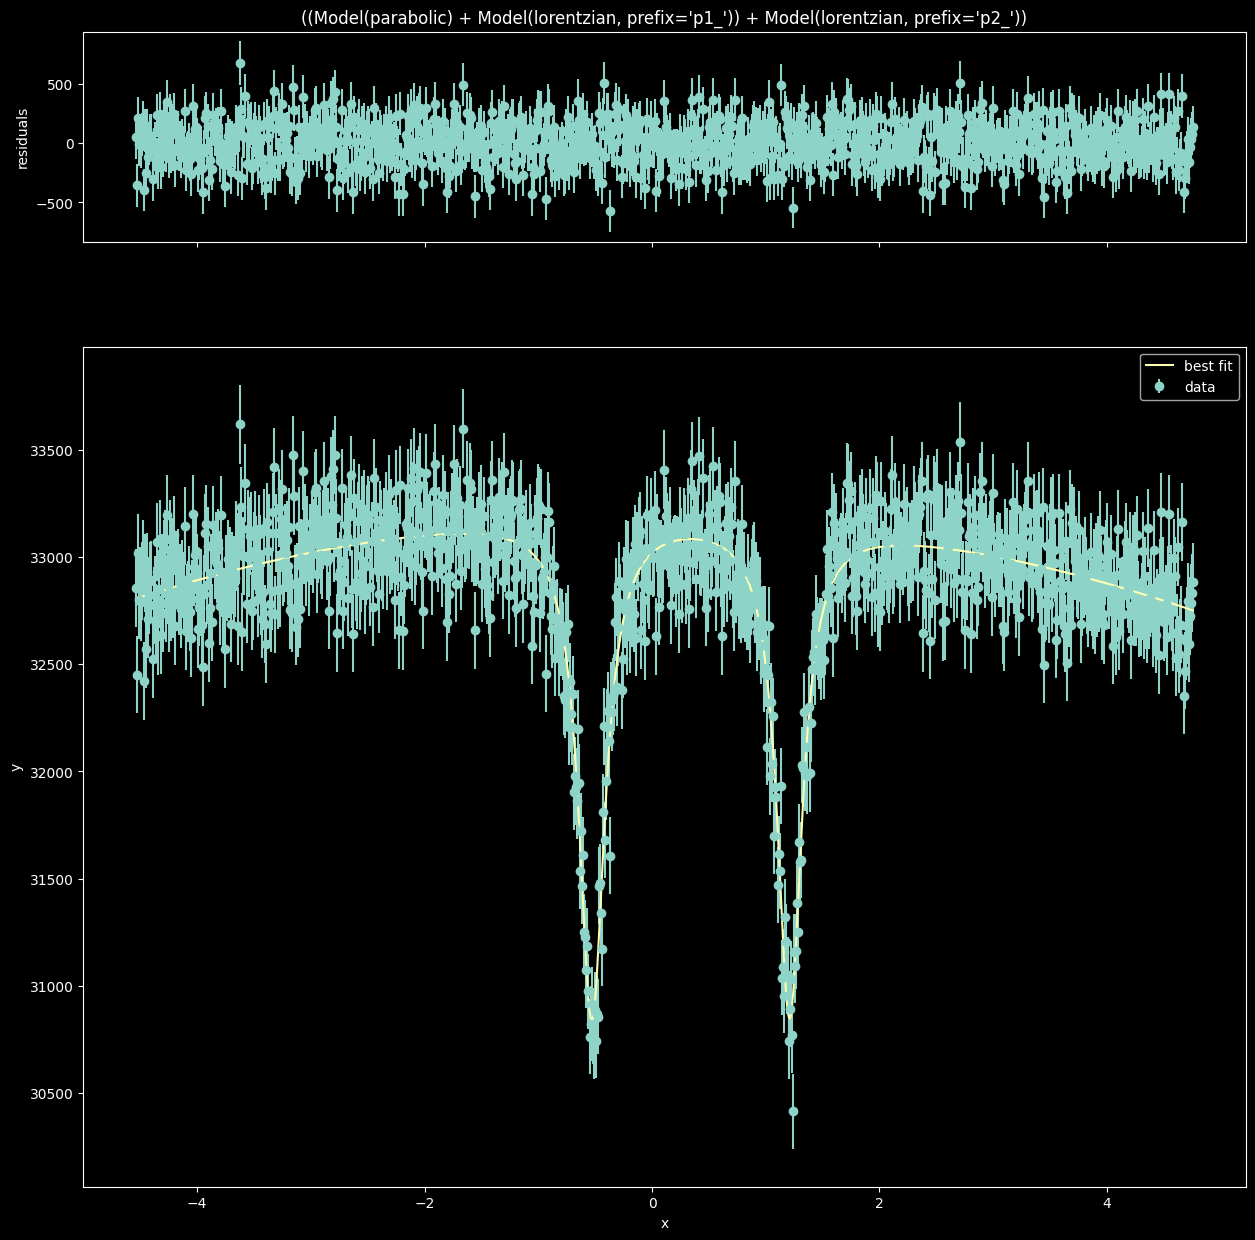

In [186]:
## Now to prepare params.
model = QuadraticModel() + LorentzianModel(prefix='p1_') + LorentzianModel(prefix='p2_')
params = model.make_params()
print(params)
Index = list(range(0,len(prus)))


# Fit Parameters!
### From the first peak:
params['p1_center'].set(value=-0.55, vary=True)
params['p1_amplitude'].set(value=-1764*.15*np.pi, vary=True)
valSigma = .15
print(valSigma)
params['p1_sigma'].set(value=valSigma, vary=True)

### From the second peak:
params['p2_center'].set(value=1.2, vary=True)
params['p2_amplitude'].set(value=-2034*.15*np.pi, vary=True)
valSigma = .15
print(valSigma)
params['p2_sigma'].set(value=valSigma, vary=True)


# Final Fitting
model_fit = model.fit(prus['Counts'][Index], params, x=prus['velocity'], weights=1/np.sqrt(prus['Counts'][Index]))
print(model_fit.fit_report(show_correl=False))
myfig=plt.figure(figsize=(15,15))
model_fit.plot(fig=myfig)
plt.savefig("./output/pruside.png")


# Save the parameters from the best fit
prus_params = model_fit.params
prus_peaks = []
for parm in prus_params:
    if parm.endswith('center'):
        prus_peaks.append(unc.ufloat(prus_params[parm].value, prus_params[parm].stderr))



prus_peaks_df = pd.DataFrame()
prus_peaks_df['Number'] = [1,2]
prus_peaks_df['Location (mm/s)'] = prus_peaks
prus_peaks_df








## Hemitite Analysis

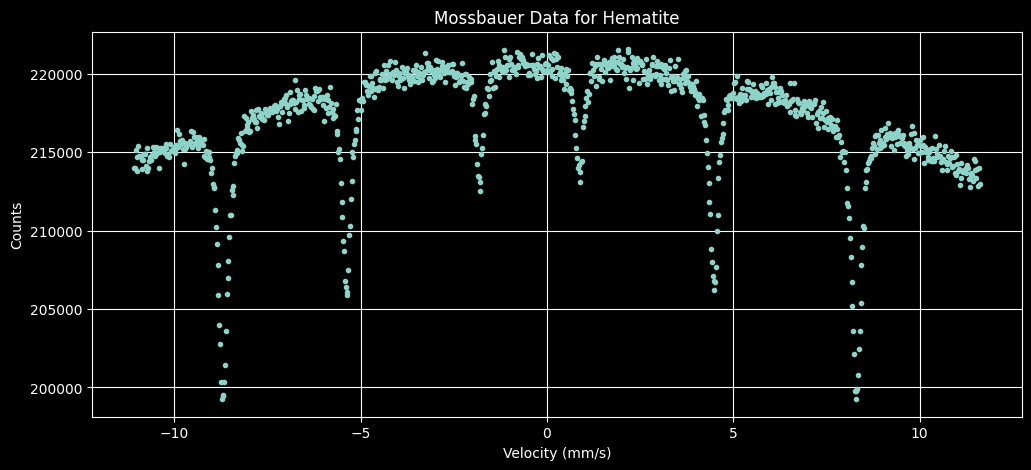

In [187]:
## Add as many cells as you need.

# First we read
hem = pd.read_csv('./Data Collected/Fe2O3_74.35mV.tsv', header=0, names=['Chan', 'Counts'], sep='\t')
hem['velocity'] = velocity_cal(hem['Chan'], Vpp['Fe2O3'])

# Next, we create a sanity/peakfinding plot
# %matplotlib widget

myfig = plt.figure(figsize=(12, 5))
plt.grid()
plt.xlabel(r'Velocity (mm/s)')
plt.ylabel(r'Counts')
plt.title('Mossbauer Data for Hematite')
plt.plot(hem['velocity'], hem['Counts'], '.')

# # Sanity plot
# myfig = plt.figure(figsize=(12,9))
# plt.grid()
# plt.xlabel(r'Velocity (mm/s)')
# plt.ylabel(r'Counts')
# plt.title('Mossbauer Data for Enriched Iron Sample')
# plt.plot(Fe['velocity'],Fe['Counts'],'.');
#
plt.savefig("./output/hemanofit");




Parameters([('a', <Parameter 'a', value=0.0, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=0.0, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=0.0, bounds=[-inf:inf]>), ('p1_amplitude', <Parameter 'p1_amplitude', value=0.0, bounds=[-inf:inf]>), ('p1_center', <Parameter 'p1_center', value=0.0, bounds=[-inf:inf]>), ('p1_sigma', <Parameter 'p1_sigma', value=0.0, bounds=[0:inf]>), ('p2_amplitude', <Parameter 'p2_amplitude', value=0.0, bounds=[-inf:inf]>), ('p2_center', <Parameter 'p2_center', value=0.0, bounds=[-inf:inf]>), ('p2_sigma', <Parameter 'p2_sigma', value=0.0, bounds=[0:inf]>), ('p3_amplitude', <Parameter 'p3_amplitude', value=0.0, bounds=[-inf:inf]>), ('p3_center', <Parameter 'p3_center', value=0.0, bounds=[-inf:inf]>), ('p3_sigma', <Parameter 'p3_sigma', value=0.0, bounds=[0:inf]>), ('p4_amplitude', <Parameter 'p4_amplitude', value=0.0, bounds=[-inf:inf]>), ('p4_center', <Parameter 'p4_center', value=0.0, bounds=[-inf:inf]>), ('p4_sigma', <Parameter 'p4_sigma', value=0.0, 

/home/coyotedark/Documents/uw/phys/431/mossbauer-spectroscopy-main/.venv/lib/python3.13/site-packages/uncertainties/core.py:526: FutureWarning: AffineScalarFunc.error_components() is currently an instance method. This method is deprecated. In a future release it will be replaced with an instance property by the same name. It will be accessed by AffineScalarFunc.error_components (with no parentheses).
  return float(sqrt(sum(delta**2 for delta in self.error_components().values())))
/home/coyotedark/Documents/uw/phys/431/mossbauer-spectroscopy-main/.venv/lib/python3.13/site-packages/uncertainties/core.py:491: FutureWarning: AffineScalarFunc.derivatives() is deprecated. It will be removed in a future release.
  for variable, derivative in self.derivatives.items():


,Number,Location (mm/s)
0,1,-5.3362+/-0.0026
1,2,-3.0727+/-0.0025
2,3,-0.8075+/-0.0032
3,4,0.9100+/-0.0033
4,5,3.1873+/-0.0026
5,6,5.4964+/-0.0026


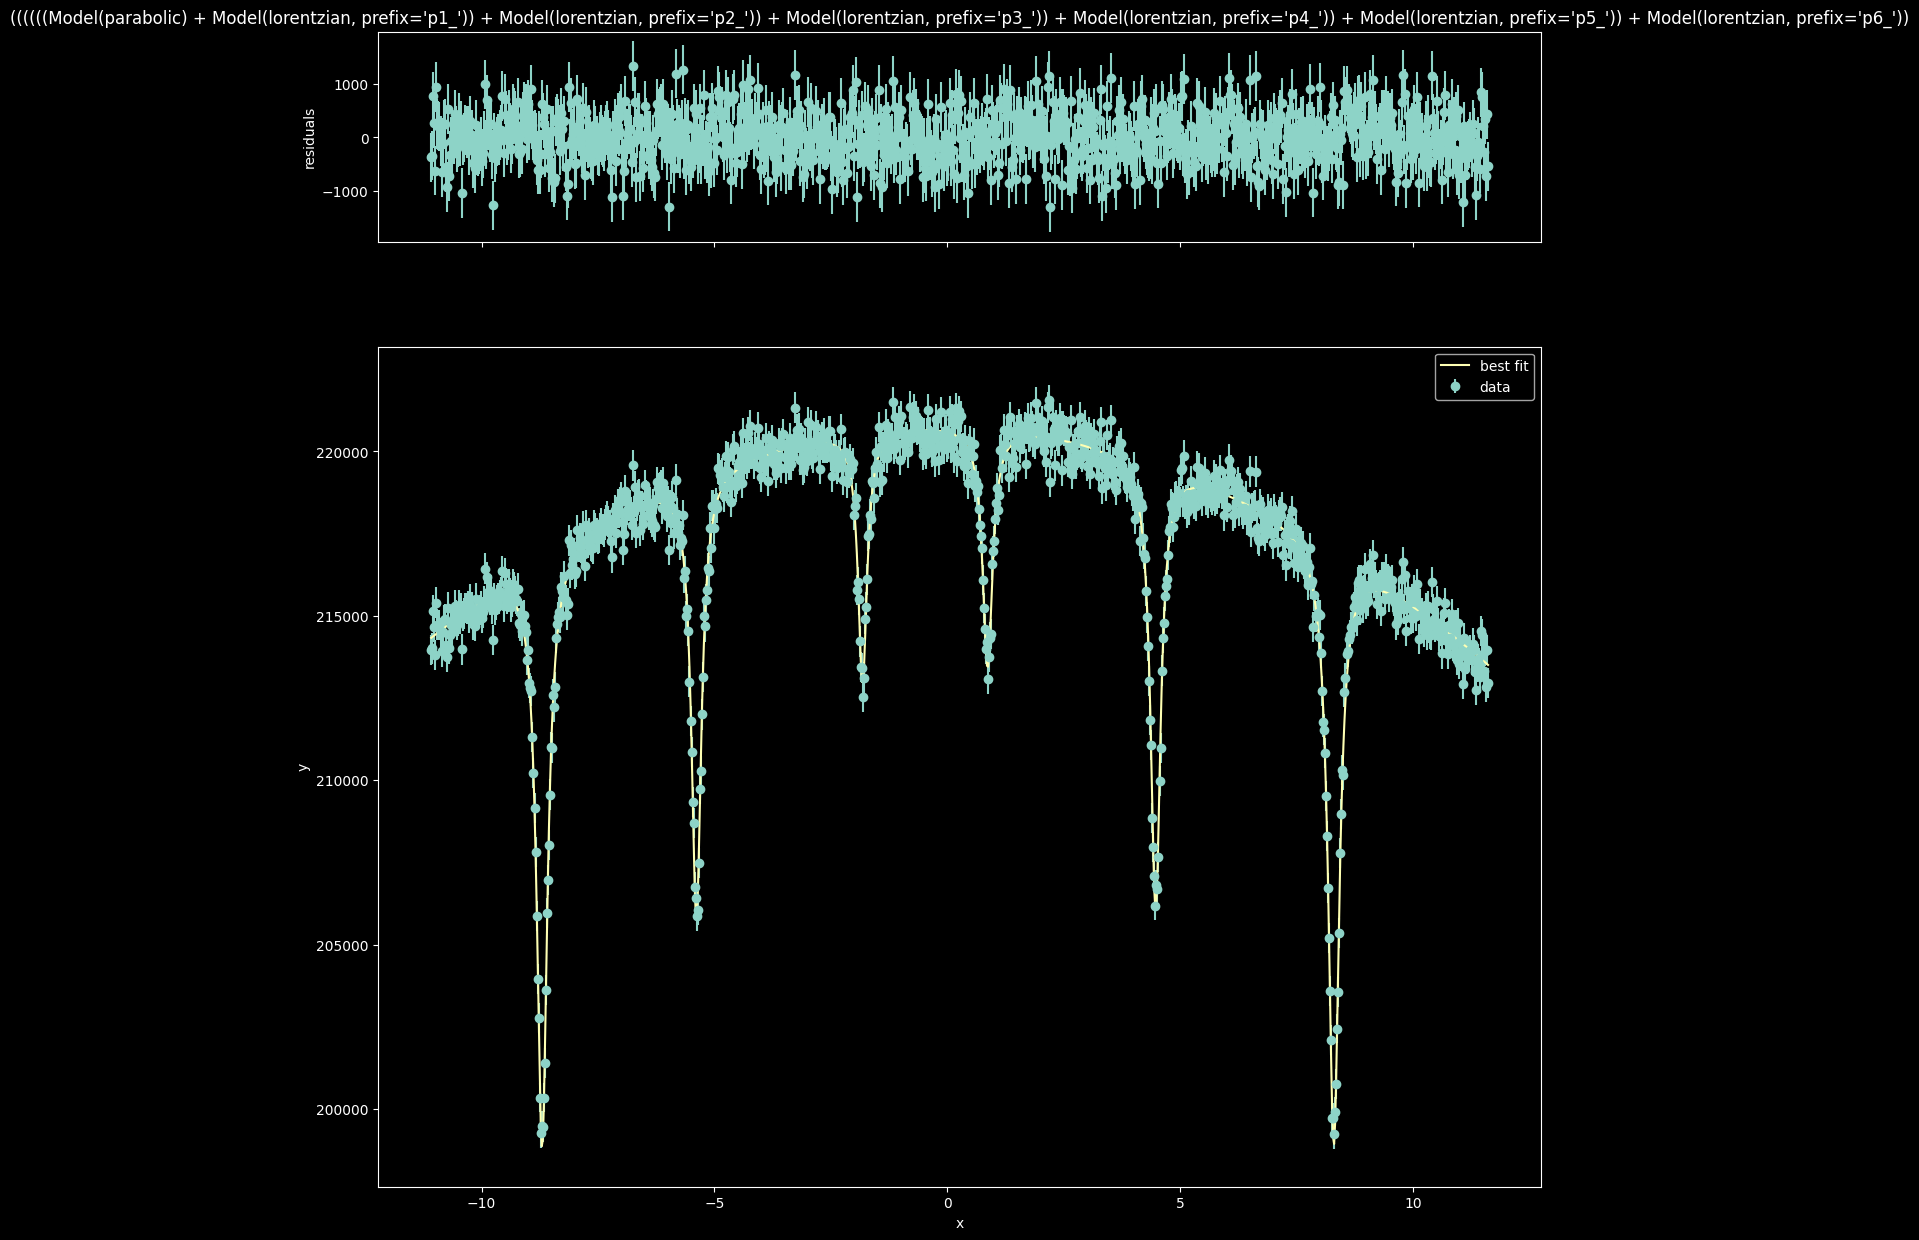

In [188]:

## Now to prepare params.
model = (QuadraticModel() + LorentzianModel(prefix='p1_')
         + LorentzianModel(prefix='p2_') + LorentzianModel(prefix='p3_')
         + LorentzianModel(prefix='p4_') + LorentzianModel(prefix='p5_')
         + LorentzianModel(prefix='p6_'))
params = model.make_params()
print(params)
Index = list(range(0, len(hem)))

# Fit Parameters!
### From the first peak:
params['p1_center'].set(value=-8.70, vary=True)
params['p1_amplitude'].set(value=-(2.14-1.99)*1e5 * .15 * np.pi, vary=True)
valSigma = .15
print(valSigma)
params['p1_sigma'].set(value=valSigma, vary=True)

### From the second peak:
params['p2_center'].set(value=-5.42, vary=True)
params['p2_amplitude'].set(value=-(2.17-2.05)*1e5  * .15 * np.pi, vary=True)
valSigma = .15
print(valSigma)
params['p2_sigma'].set(value=valSigma, vary=True)

### From the third peak:
params['p3_center'].set(value=-1.83, vary=True)
params['p3_amplitude'].set(value=-(2.18-2.12)*1e5 * .15 * np.pi, vary=True)
valSigma = .15
print(valSigma)
params['p3_sigma'].set(value=valSigma, vary=True)

### From the fourth peak:
params['p4_center'].set(value=0.83, vary=True)
params['p4_amplitude'].set(value=-(2.18-2.13)*1e5* .15 * np.pi, vary=True)
valSigma = .15
print(valSigma)
params['p4_sigma'].set(value=valSigma, vary=True)

### From the fifth peak:
params['p5_center'].set(value=4.43, vary=True)
params['p5_amplitude'].set(value=-(2.17-2.06)*1e5 * .15 * np.pi, vary=True)
valSigma = .15
print(valSigma)
params['p5_sigma'].set(value=valSigma, vary=True)

### From the sixth peak:
params['p6_center'].set(value=8.24, vary=True)
params['p6_amplitude'].set(value= -(2.14-1.99)*1e5 * .15 * np.pi, vary=True)
valSigma = .15
print(valSigma)
params['p6_sigma'].set(value=valSigma, vary=True)



# Final Fitting
model_fit = model.fit(hem['Counts'][Index], params, x=hem['velocity'], weights=1 / np.sqrt(hem['Counts'][Index]))
print(model_fit.fit_report(show_correl=False))
myfig = plt.figure(figsize=(15, 15))
model_fit.plot(fig=myfig)
plt.savefig("./output/hem.png")


# Save the parameters from the best fit
hem_params = model_fit.params
hem_peaks = []
for parm in hem_params:
    if parm.endswith('center'):
        hem_peaks.append(unc.ufloat(Fe_params[parm].value, Fe_params[parm].stderr))



hem_peaks_df = pd.DataFrame()
hem_peaks_df['Number'] = [1,2,3,4,5,6]
hem_peaks_df['Location (mm/s)'] = hem_peaks
hem_peaks_df



## Calculate final results

Carry out the analysis below that is relevant to your sample types

### Enriched iron and Natural iron

1. Start with isomer shift $\delta$. This is just the average of all peak locations. The number would be relative to the source Co-57/Rh

2. Next calculate the magnetic field $B$ and excited-state moment $\mu_e$ from the enriched-foil data.  

For the field, we first need the transitions that start from different ground states and end at the same excited states.  There are two pairs of these, one pair ends at -1/2: peaks 2 & 4, and the other ends at +1/2, peaks 1 and 3. The differences between these will give $\mu_gB$.  From this get $B$ with $\mu_g = +0.09062\mu_n$ where $\mu_n = 3.1525\times10^{-8}$ eV/T 

You will need to convert to energy with Doppler formula
$$\frac{\Delta E}{E} = \frac{v}{c}$$
where $E = 14.412497$ keV.

To get the excited state moment, you will need the excited state splitting. These pairs that start at the same ground state but end at different excited states: peaks 0-1, 1-2, 3-4, and 4-5.

3. From this calculate the excited state moment $\mu_e$, and compare to $-0.1549\mu_n$. 

4. Repeat the above for any other natural iron samples you may have. (Don't forget to apply the correct calibration constant for each one.)

#### Magnetic Field $(B)$ Calculation

First, the groud state is split into $\pm 1/2$. To get $\mu_gB$, we first get the pairs of peaks that start at different ground states but end at the difference in the excited states.

Recall that our peak data is stored in `Fe_peaks_df`

In [189]:
## Lets make this easier, setting the index to be the number:
Fe_peaks_df.set_index('Number', inplace=True)

## The peak data:
Fe_peaks_df

,Location (mm/s)
Number,
1,-5.3362+/-0.0026
2,-3.0727+/-0.0025
3,-0.8075+/-0.0032
4,0.9100+/-0.0033
5,3.1873+/-0.0026
6,5.4964+/-0.0026


In [190]:
mu_g = 0.09062

def conv_to_eng(ve):
    return ve/sp.constants.c * 14.412497e3 #E

diff2_4 = Fe_peaks_df["Location (mm/s)"].loc[4] - Fe_peaks_df["Location (mm/s)"].loc[2]
diff1_3 = Fe_peaks_df["Location (mm/s)"].loc[3] - Fe_peaks_df["Location (mm/s)"].loc[1]
E_g = conv_to_eng(diff1_3 - diff2_4)
mu_n = 3.1525e-8
B = E_g / (0.09062 * mu_n)
print(f"First pair: {diff2_4}")
print(f"Second pair: {diff1_3}")
print(f"E_g: {E_g}")
print(f"B: {B}")



First pair: 3.983+/-0.004
Second pair: 4.529+/-0.004
E_g: (2.625+/-0.028)e-05
B: (9.19+/-0.10)e+03


/home/coyotedark/Documents/uw/phys/431/mossbauer-spectroscopy-main/.venv/lib/python3.13/site-packages/uncertainties/core.py:526: FutureWarning: AffineScalarFunc.error_components() is currently an instance method. This method is deprecated. In a future release it will be replaced with an instance property by the same name. It will be accessed by AffineScalarFunc.error_components (with no parentheses).
  return float(sqrt(sum(delta**2 for delta in self.error_components().values())))
/home/coyotedark/Documents/uw/phys/431/mossbauer-spectroscopy-main/.venv/lib/python3.13/site-packages/uncertainties/core.py:491: FutureWarning: AffineScalarFunc.derivatives() is deprecated. It will be removed in a future release.
  for variable, derivative in self.derivatives.items():


next we need to find the excited state moments. First, we should calculate the differences in all of the excited state peaks, they are:

- 1 & 2
- 2 & 3
- 4 & 5
- 5 & 6

In [191]:
diff1_2 = Fe_peaks_df["Location (mm/s)"].loc[2] - Fe_peaks_df["Location (mm/s)"].loc[1]
diff2_3 = Fe_peaks_df["Location (mm/s)"].loc[3] - Fe_peaks_df["Location (mm/s)"].loc[2]
diff4_5 = Fe_peaks_df["Location (mm/s)"].loc[5] - Fe_peaks_df["Location (mm/s)"].loc[4]
diff5_6 = Fe_peaks_df["Location (mm/s)"].loc[6] - Fe_peaks_df["Location (mm/s)"].loc[5]

excited_state_calc = [diff1_2, diff2_3, diff4_5, diff5_6]
excited_state_calc

[2.263516168490313+/-0.0036049168300768273,
 2.2652277585250156+/-0.004095167189410353,
 2.2772204958069815+/-0.004183992705713312,
 2.309101806371507+/-0.0036102352186409706]

In [192]:

excited_state = sum(excited_state_calc)/len(excited_state_calc)
print(excited_state)
mu_e = conv_to_eng(excited_state)/B

print(mu_e/mu_n)

2.2788+/-0.0015
0.378+/-0.004


### Sodium nitroprusside~ Quadrapole Splitting

Need isomer shift relative to Fe foil and quadrupole split, both in mm/s units.

Compare results to literature values of $-0.257$ mm/s for the isomer shift, relative to Fe and $1.7048$ mm/s for the quadrupole splitting.

#### Isomer Shift
The isomer shift of this reaction is calculated by taking an average of the two peaks. This should show the center of the two peaks, and how far it is away from the origin.
Recall from above that our peaks after line fitting are stored in `hem_peaks_df`:


In [193]:
# hem_peaks_df['Energy Shift'] = hem_peaks_df['Location (mm/s)'].apply(energy_shift)
# hem_peaks_df

isomer_shift = prus_peaks_df['Location (mm/s)'].values.mean()
# isomer_shift


#### Quadrapole Shift

The quadrapole shift in this senario would just be difference in the two peaks.

In [194]:
quadrapole_shift = prus_peaks_df["Location (mm/s)"].loc[1] - prus_peaks_df["Location (mm/s)"].loc[0]
quadrapole_shift

1.7391617735097786+/-0.004261444403213716

### Hematite (Rust)

Analysis proceeds in same manner as for enriched Fe foil. Find $\delta$, $B$, $\mu_e$. 

#### Then find quadrupole splitting

From Figure 2 in Kistner & Sunyar (PRL Vol. 4, p.412, 1960) peaks 0-1 are closer together than 1-2 by $2\varepsilon$ and peaks 4-5 are farther apart than peaks 3-4.  To find $\varepsilon$ we note that (4-5)-(0-1) should be equal to $4\varepsilon$.

Compare to following results in Kistner & Sunyar:
* G.S Splitting = $6.11\pm0.05$ mm/s
* E.S. splitting = $3.45\pm0.03$ mm/s
* Isomer shift relative to Fe = $0.47\pm0.03$ mm/s
* Quadrupole splitting $\varepsilon = 0.12\pm0.03$ mm/s

To start, we will evaluate the given equation to find the Quadrupole $\varepsilon$:

In [195]:

# Now to calculations
diff5_4 = hem_peaks_df["Location (mm/s)"].loc[4] - hem_peaks_df["Location (mm/s)"].loc[5]
diff1_0 = hem_peaks_df["Location (mm/s)"].loc[0] - hem_peaks_df["Location (mm/s)"].loc[1]

eps = (diff5_4 - diff1_0) / 4

eps

-0.011396409470298519+/-0.0012754710817401637

Using previous methods, we can also find the other values as well:

In [196]:
# Isomer shift
hem_peaks_df["Location (mm/s)"].values.mean()

0.06286788650871096+/-0.0011484197984614952

In [197]:
# GS and ES:
# From the Panopto Recording

# Again, to make things easier
hem_peaks_df.set_index('Number', inplace=True)

# GS
diff2_4 = hem_peaks_df["Location (mm/s)"].loc[4] - hem_peaks_df["Location (mm/s)"].loc[4]
diff3_5 = hem_peaks_df["Location (mm/s)"].loc[5] - hem_peaks_df["Location (mm/s)"].loc[3]
gs = diff3_5 - diff2_4
print(f"gs: {gs}")

# ES
diff1_2 = hem_peaks_df["Location (mm/s)"].loc[2] - hem_peaks_df["Location (mm/s)"].loc[1]
diff2_3 = hem_peaks_df["Location (mm/s)"].loc[3] - hem_peaks_df["Location (mm/s)"].loc[2]
diff4_5 = hem_peaks_df["Location (mm/s)"].loc[5] - hem_peaks_df["Location (mm/s)"].loc[4]
diff5_6 = hem_peaks_df["Location (mm/s)"].loc[6] - hem_peaks_df["Location (mm/s)"].loc[6]

excited_state_calc = [diff1_2, diff2_3, diff4_5, diff5_6]
excited_state = sum(excited_state_calc)/len(excited_state_calc)
print(f"excited_state: {excited_state}")

gs: 3.995+/-0.004
excited_state: 1.7015+/-0.0015
